# Train on generated datasets

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import time
import datetime
import json
import pickle
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from tensorflow.keras import Input
from tensorflow.keras import Model
from tcn import TCN

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

from utils import *
from models import *
import config

Using TensorFlow backend.


In [2]:
STUDY_PATH = config.STUDY_PATH
GEN_DFS_PATH = config.GEN_DFS_PATH
TRAIN_VAL_RATIO = config.TRAIN_VAL_RATIO
N_STEPS = config.N_STEPS
N_FEATURES_IN = config.N_FEATURES_IN
N_FEATURES_OUT = config.N_FEATURES_OUT
TPL_PATH = config.TPL_PATH

n_input = N_STEPS * N_FEATURES_IN
err_upper_limit = 14
pd.options.display.max_columns = 25

In [3]:
TPL_PATH, STUDY_PATH, GEN_DFS_PATH

('C:\\Users\\Asus\\Desktop\\Skoltech\\Multiphase flows\\olga_proj\\Subsea_Study[7]',
 'C:/Users/Asus/Desktop/Skoltech/Multiphase flows/data/Subsea_Study[7]',
 'C:/Users/Asus/Desktop/Skoltech/Multiphase flows/data/Subsea_Study[7]/gens')

In [4]:
TPL_PATH2 = re.sub('4', '7', TPL_PATH)
STUDY_PATH2 = re.sub('4', '7', STUDY_PATH)
GEN_DFS_PATH2 = re.sub('4', '7', GEN_DFS_PATH)

In [5]:
# load datasets

dfs = []
inputss = []
outputss = []
out_names = ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']

for file in os.listdir(GEN_DFS_PATH):
    df = pd.read_csv(f'{GEN_DFS_PATH}/{file}')
#     if df.shape[0] >= N_STEPS * 10:
    if df.shape[0] >= 50:
        outputs = df[out_names]
        inputs = df.drop(columns=out_names, axis=1)

        dfs.append(df)
        inputss.append(inputs)
        outputss.append(outputs)

In [6]:
for file in os.listdir(GEN_DFS_PATH2):
    df = pd.read_csv(f'{GEN_DFS_PATH2}/{file}')
#     if df.shape[0] >= N_STEPS * 10:
    if df.shape[0] >= 50:
        outputs = df[out_names]
        inputs = df.drop(columns=out_names, axis=1)

        dfs.append(df)
        inputss.append(inputs)
        outputss.append(outputs)

In [7]:
len(dfs)

610

In [63]:
# print number of valid files

tpl_files = list_ext(TPL_PATH, 'tpl')

print (f'{len(dfs)} out of {len(os.listdir(GEN_DFS_PATH))} ({np.round(len(dfs)/len(os.listdir(GEN_DFS_PATH))*100, 1)}%) without errors')
print (f'which means')
print (f'{len(dfs)} out of {len(tpl_files)} ({np.round(len(dfs)/len(tpl_files)*100, 1)}%) without errors total')

429 out of 560 (76.6%) without errors
which means
429 out of 560 (76.6%) without errors total


# XGB

(MSE, 3 layers, 100 neurons, do=0.2, lr=1e-4, epochs=500)

In [14]:
MODEL_NAME = 'XGB-1'
LOSS = 'mse'

In [15]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mae', optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 500
    import tensorflow.keras.optimizers
    batch_x = 25
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=50, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, max_depth=5, reg_alpha=1))

In [16]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [17]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [18]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    model_inf = model.fit(X_train_shuffle[:-X_train_shuffle.shape[0]%batch_x], y_train_shuffle[:-X_train_shuffle.shape[0]%batch_x], epochs=n_epochs, verbose=1, validation_data=(X_valid[:-X_valid%batch_x], y_valid[:-X_valid%batch_x]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_train_shuffle, y_train_shuffle)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

C:\Users\Asus\Anaconda3\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [19]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

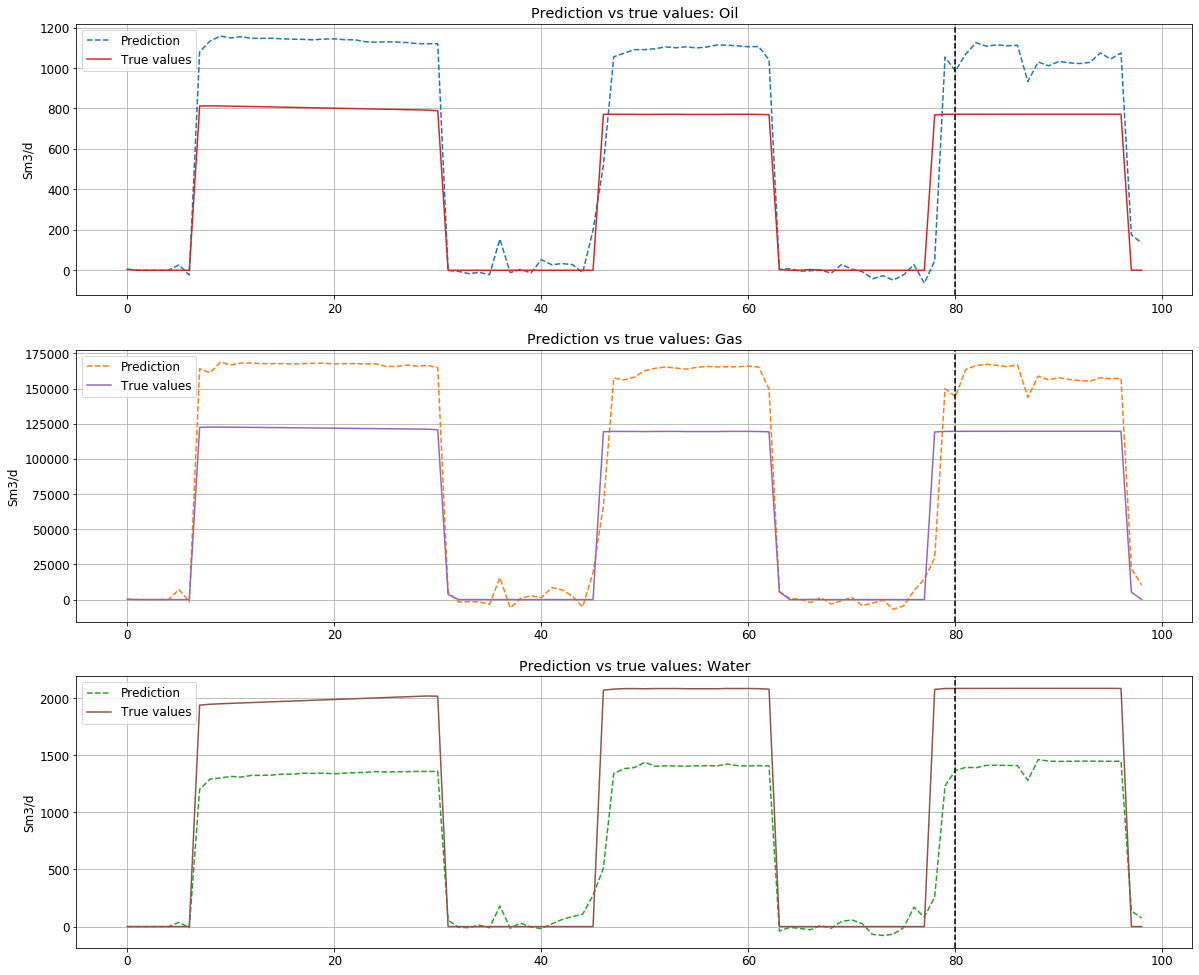

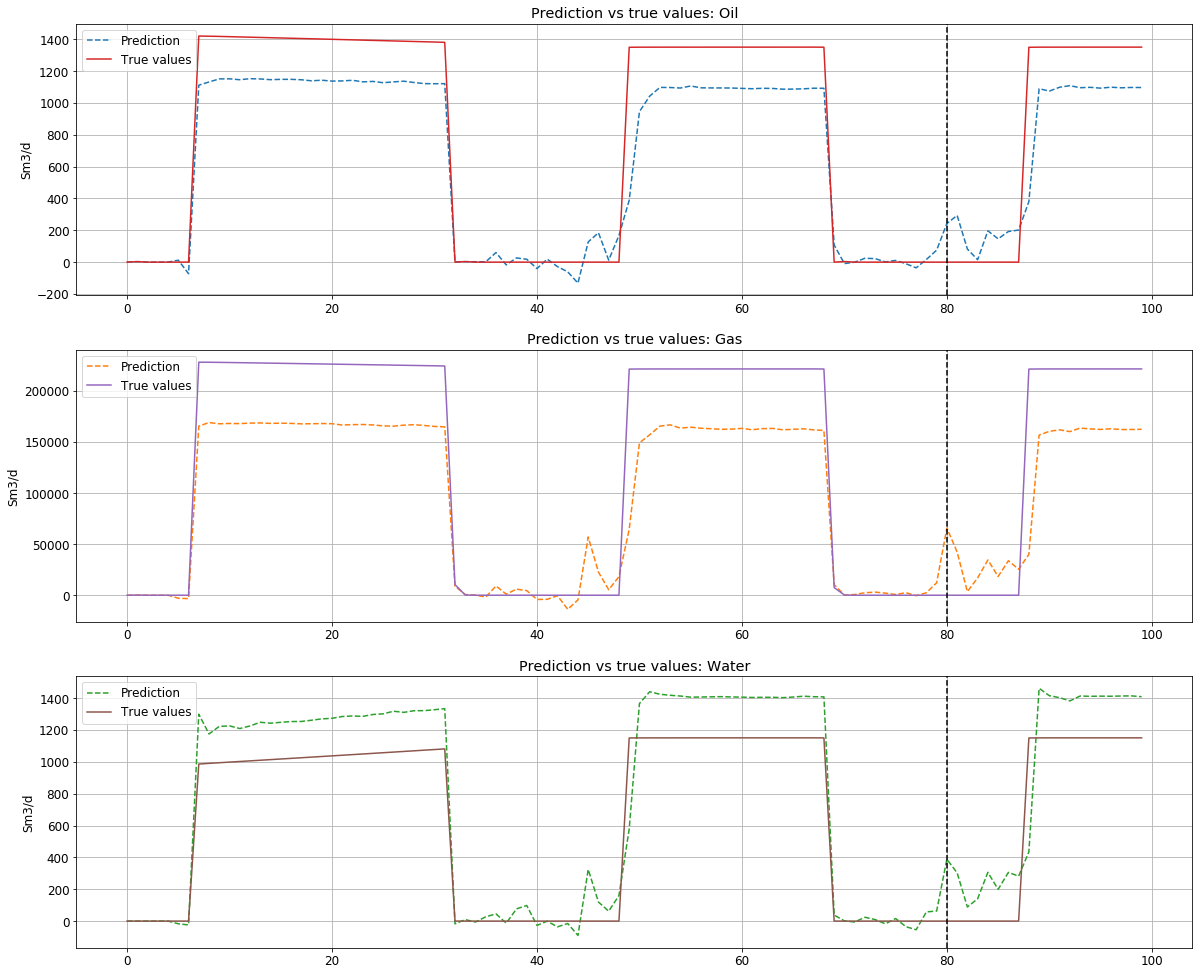

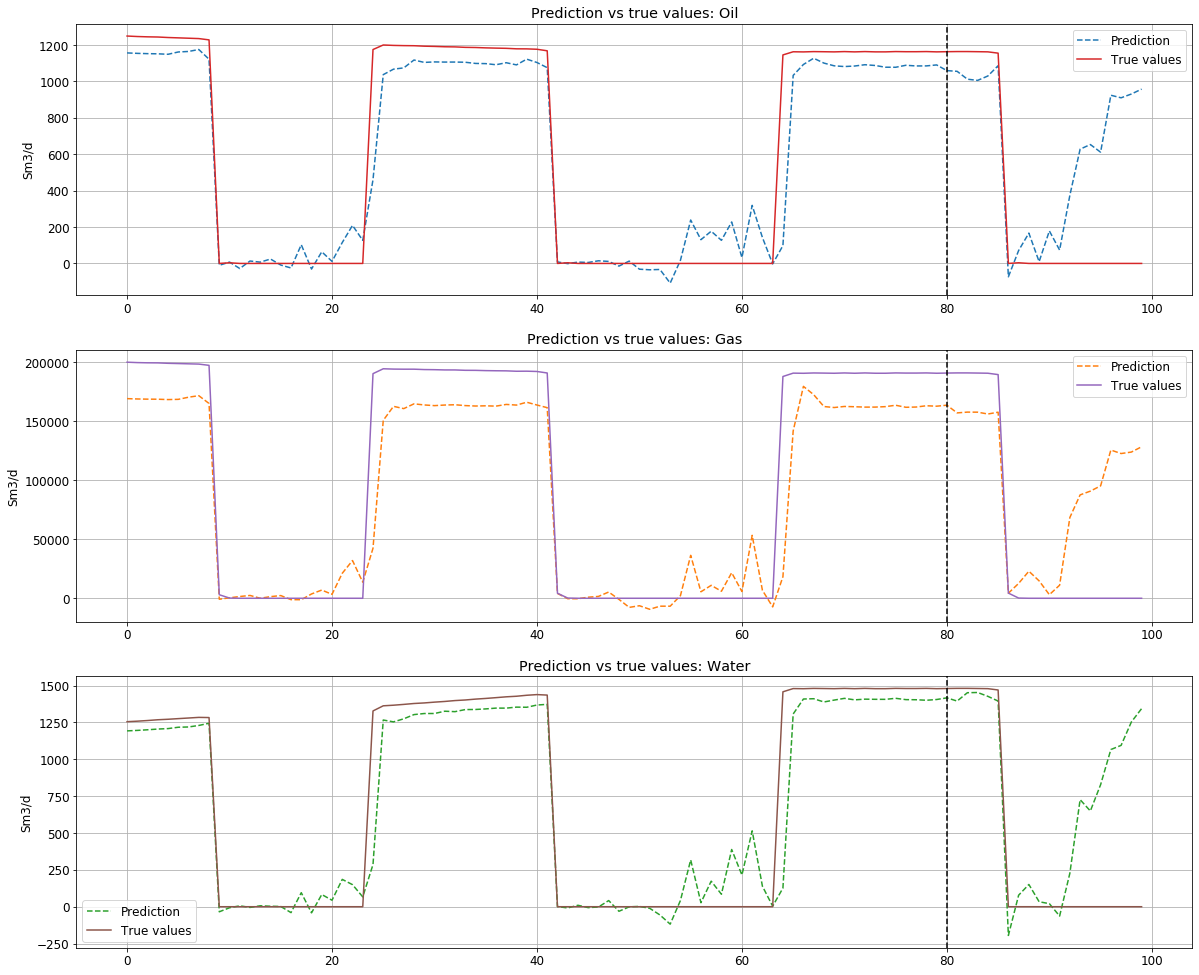

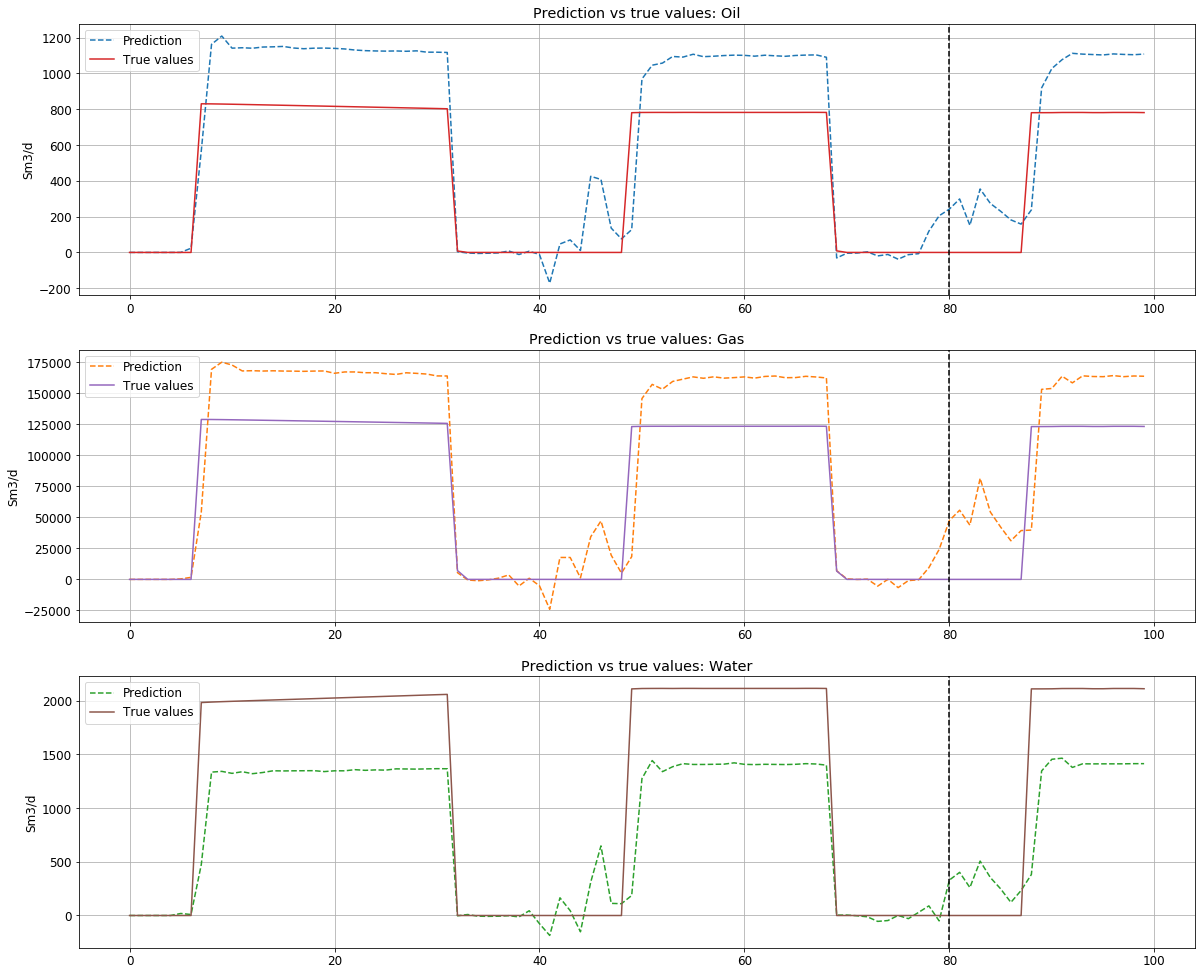

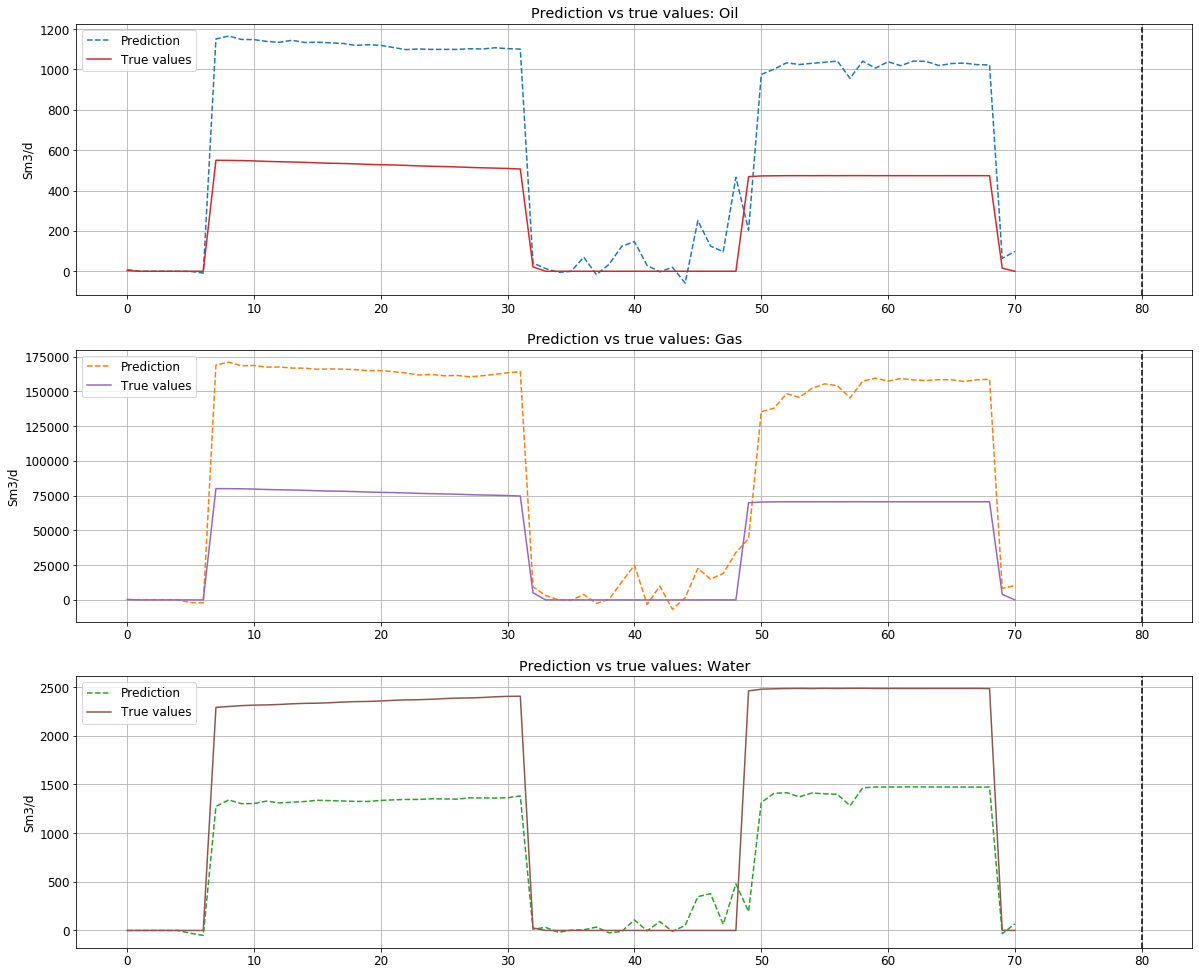

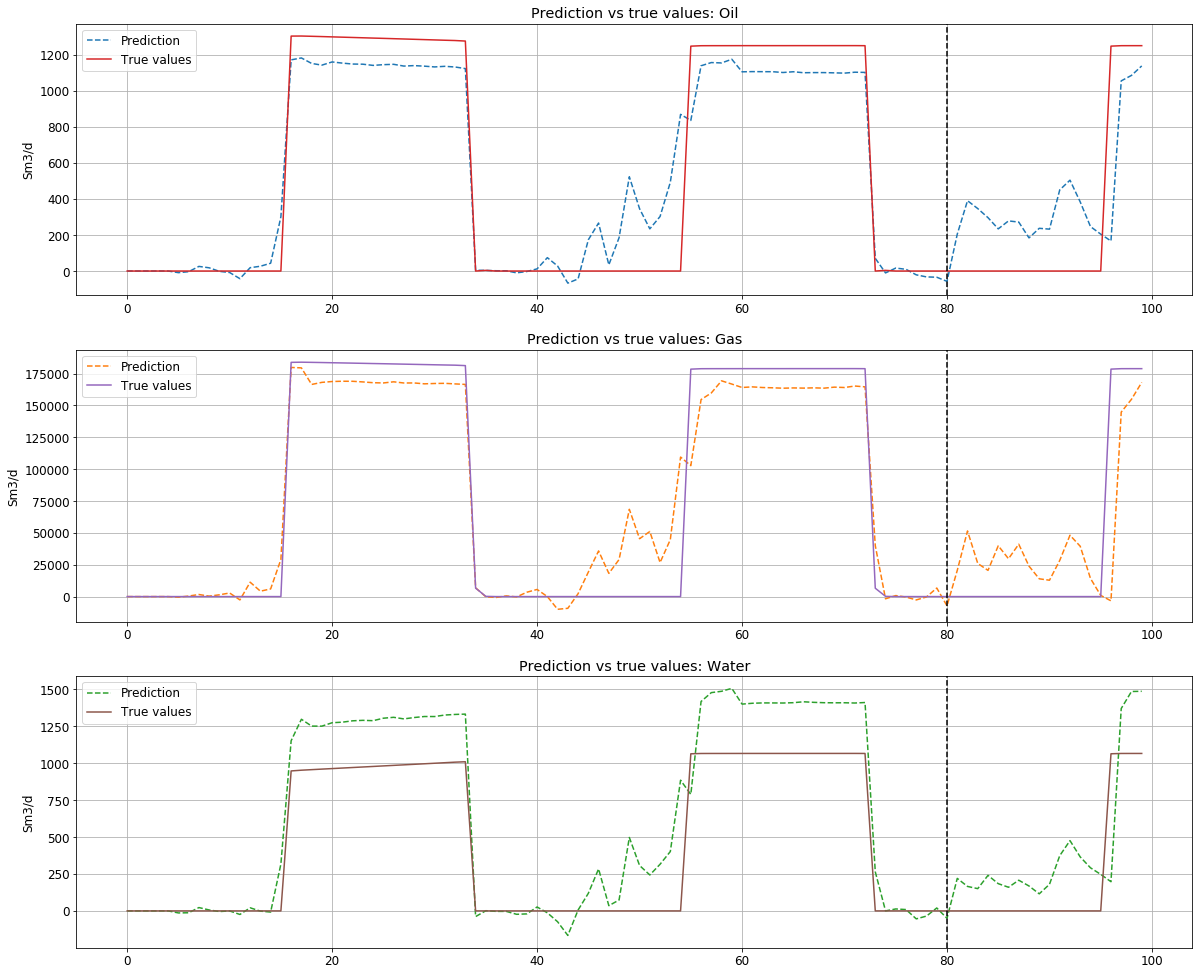

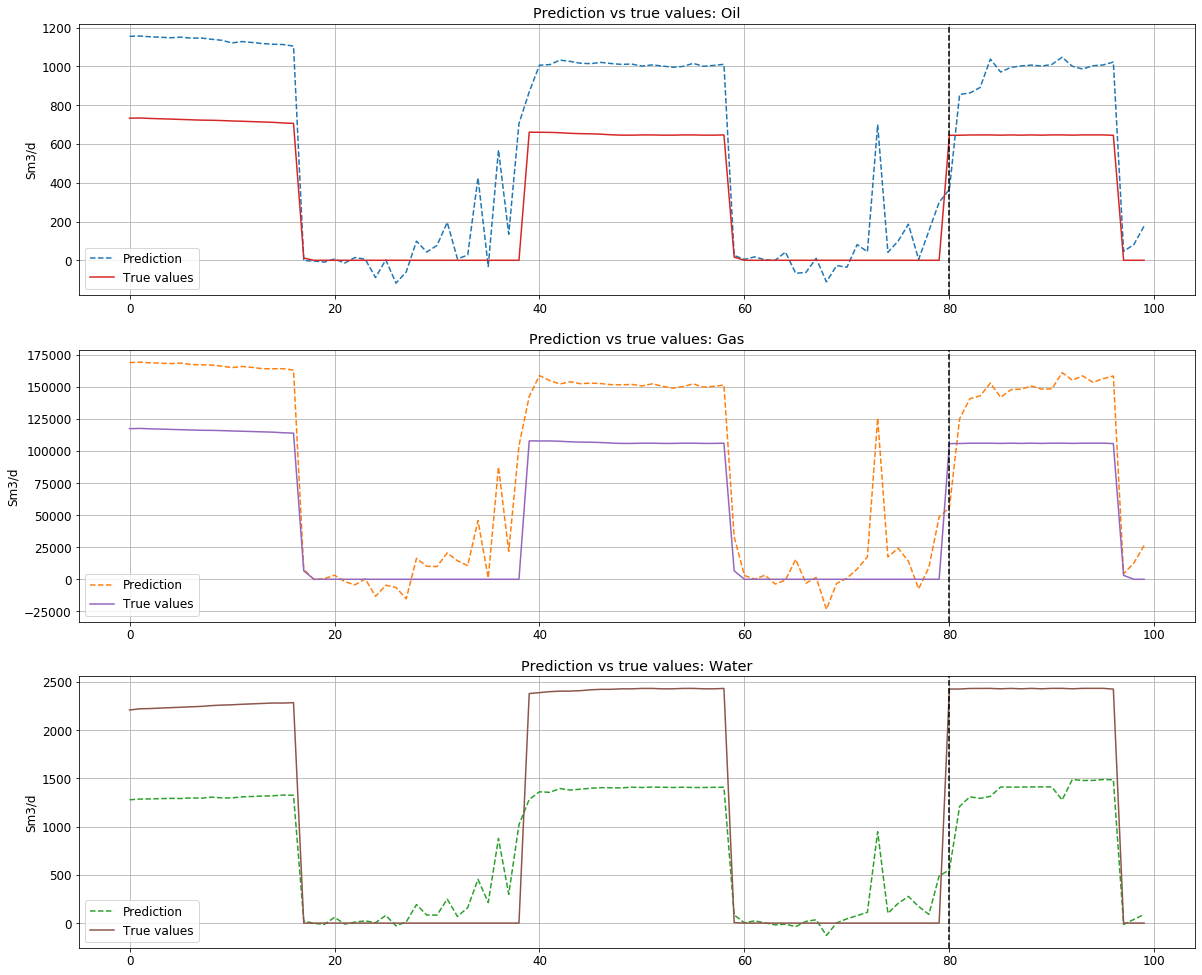

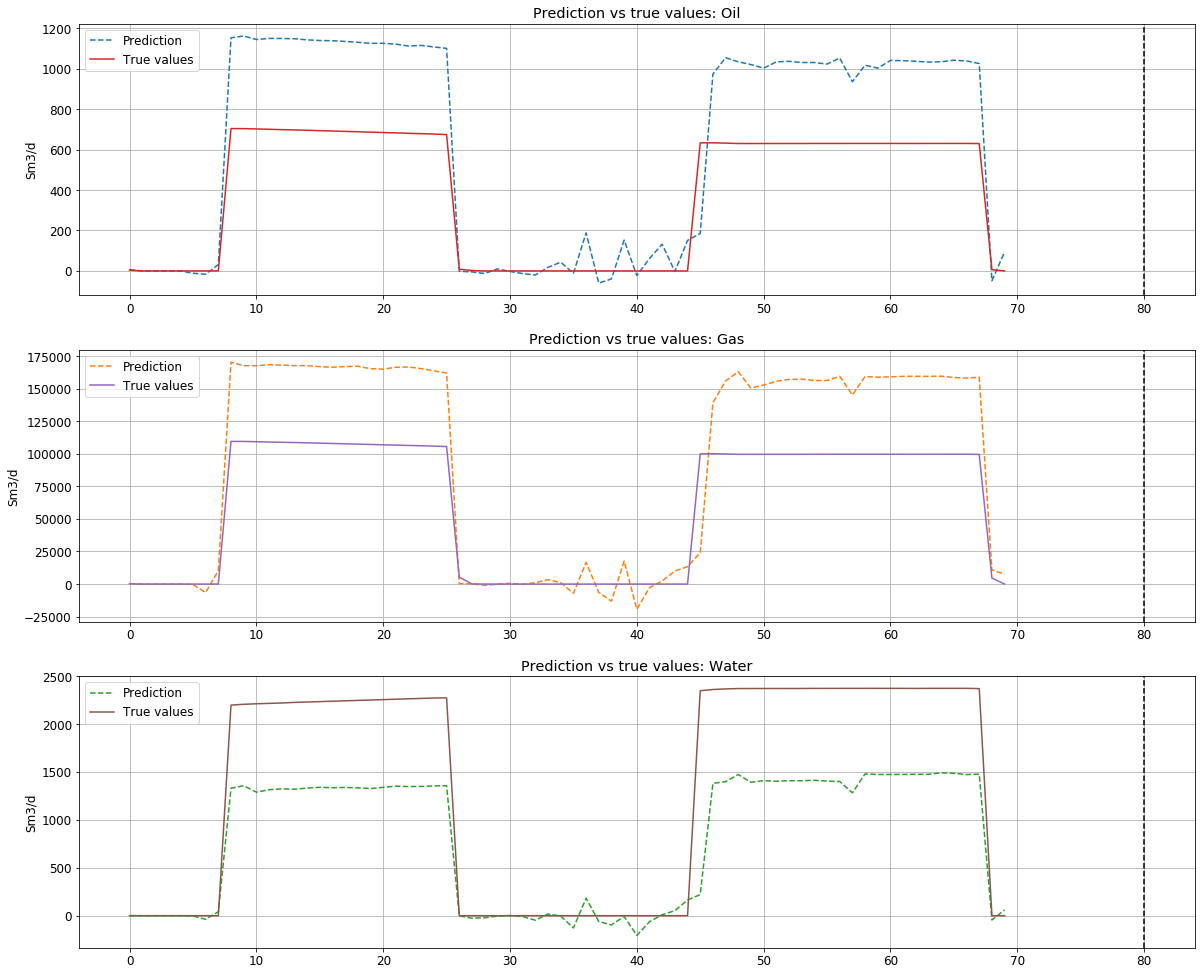

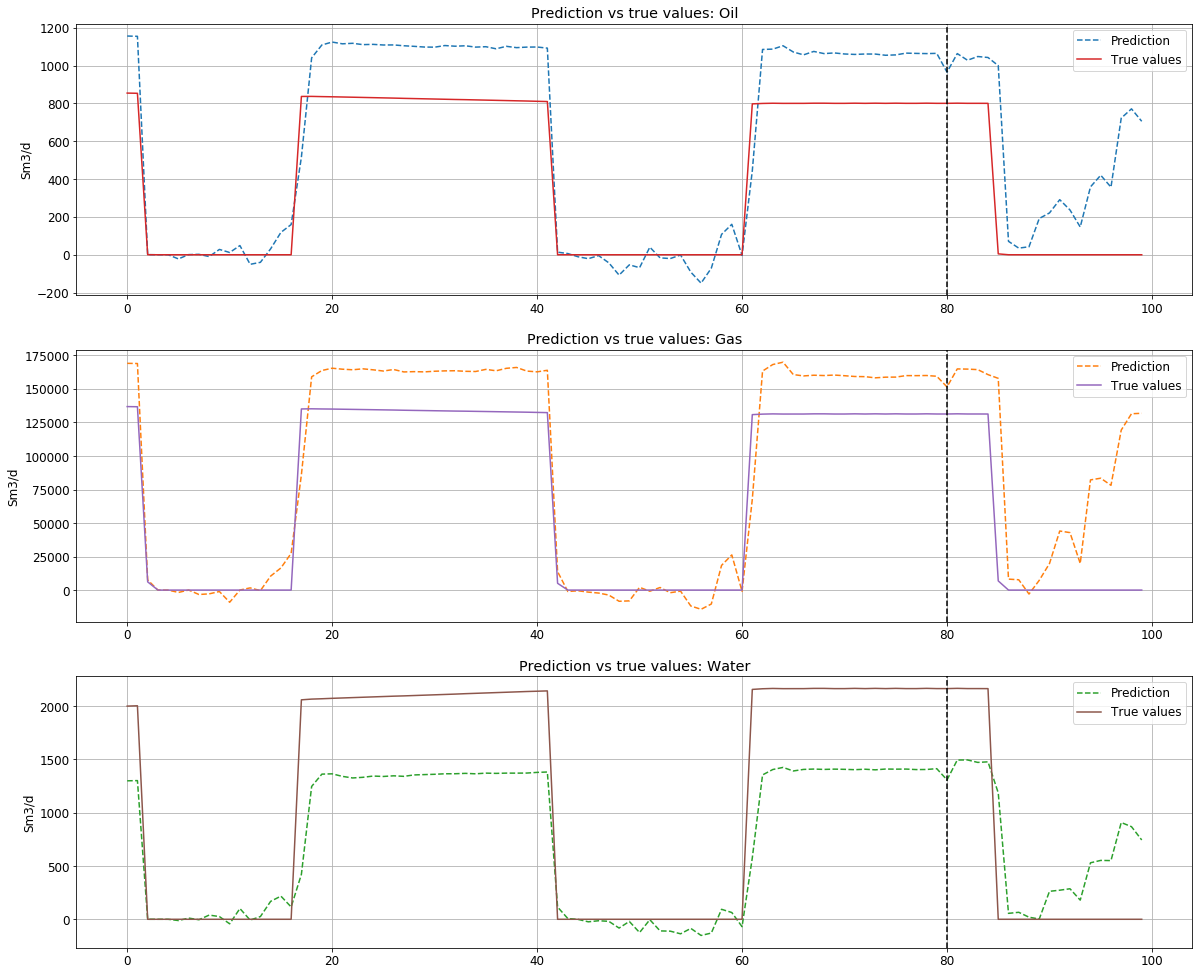

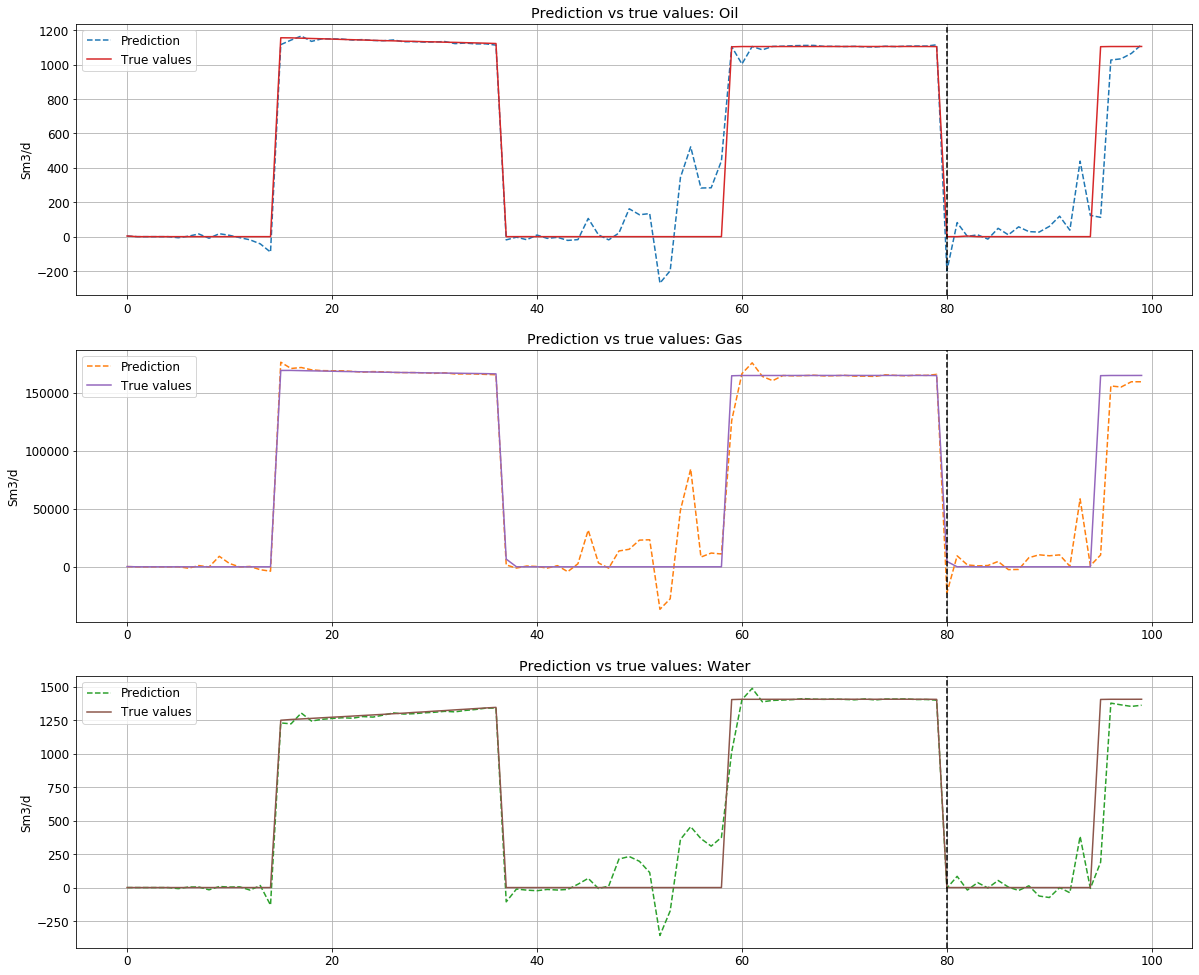

In [20]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [17]:
# if 'XGB' in MODEL_NAME:
#     pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
# elif 'TCN' in MODEL_NAME:
#     # get model as json string and save to file
#     model_as_json = model.to_json()
#     with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
#         json_file.write(model_as_json)
        
#     # save weights to file (for this format, need h5py installed)
#     model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
# else:
#     model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')

# TCN

In [34]:
MODEL_NAME = 'TCN-1'
LOSS = 'mae'

In [35]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [36]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mae', optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 100
    batch_x = 30
    import tensorflow.keras.optimizers
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=10, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, max_depth=5, reg_alpha=1))

In [37]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [38]:
X_train_shuffle.shape, X_valid.shape

((50977, 5, 6), (3209, 5, 6))

In [39]:
shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
shape_train, shape_test

(50970, 3180)

In [40]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_train_shuffle, y_train_shuffle)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 50970 samples, validate on 3180 samples
Epoch 1/100
50970/50970 [==============================] - 10s 189us/sample - loss: 0.0751 - val_loss: 0.0328
Epoch 2/100
50970/50970 [==============================] - 9s 169us/sample - loss: 0.0396 - val_loss: 0.0317
Epoch 3/100
50970/50970 [==============================] - 9s 170us/sample - loss: 0.0353 - val_loss: 0.0268
Epoch 4/100
50970/50970 [==============================] - 9s 173us/sample - loss: 0.0327 - val_loss: 0.0240
Epoch 5/100
50970/50970 [==============================] - 9s 180us/sample - loss: 0.0313 - val_loss: 0.0267
Epoch 6/100
50970/50970 [==============================] - 9s 174us/sample - loss: 0.0303 - val_loss: 0.0279
Epoch 7/100
50970/50970 [==============================] - 9s 175us/sample - loss: 0.0296 - val_loss: 0.0247
Epoch 8/100
50970/50970 [==============================] - 9s 181us/sample - loss: 0.0289 - val_loss: 0.0250
Epoch 9/100
50970/50970 [==============================] - 9s 173us/sample - l

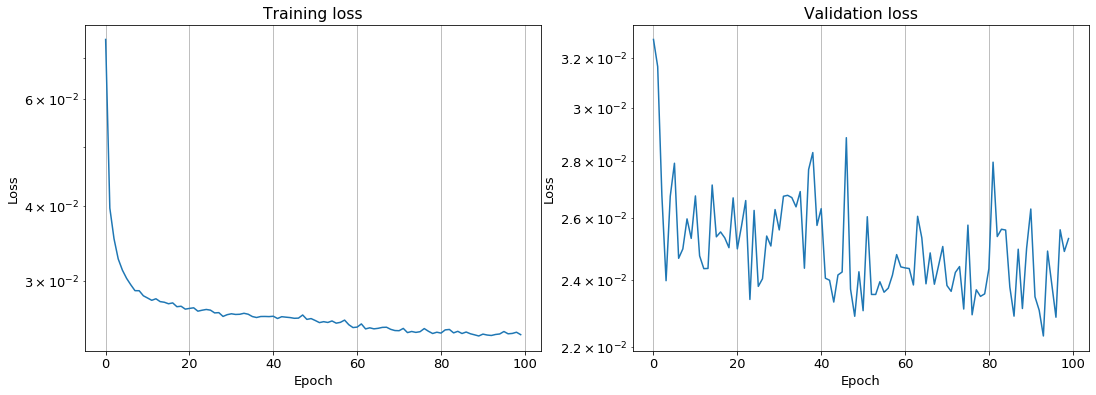

In [41]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

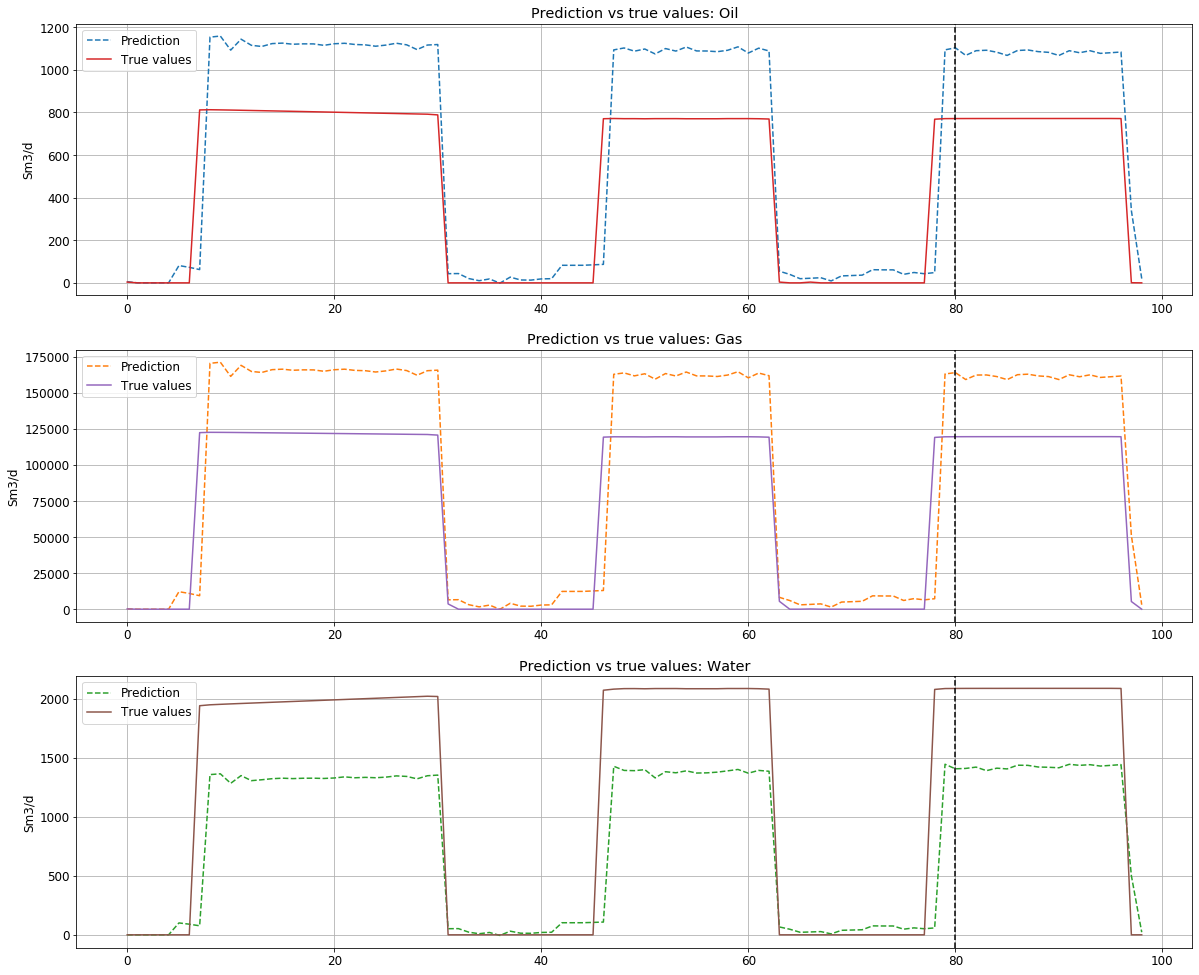

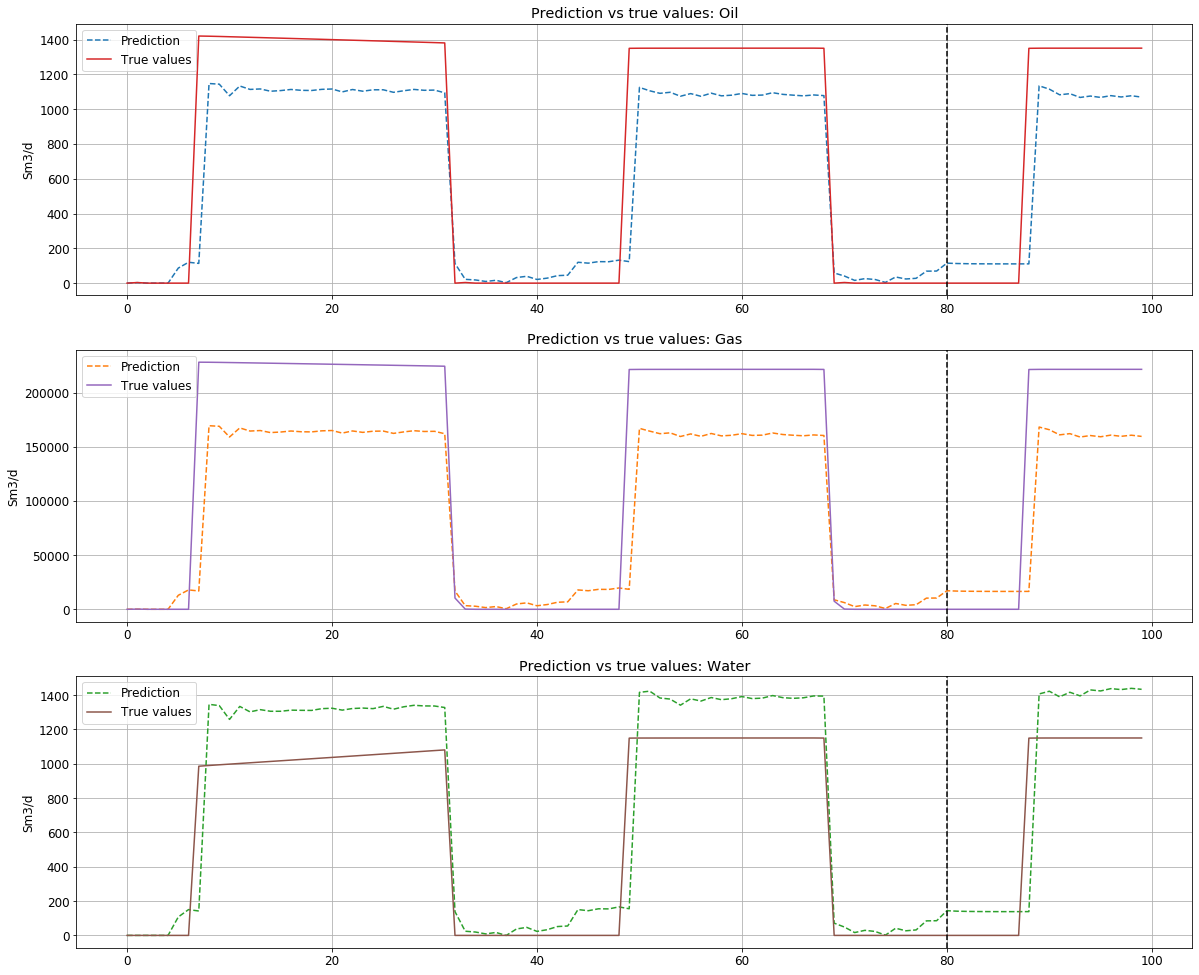

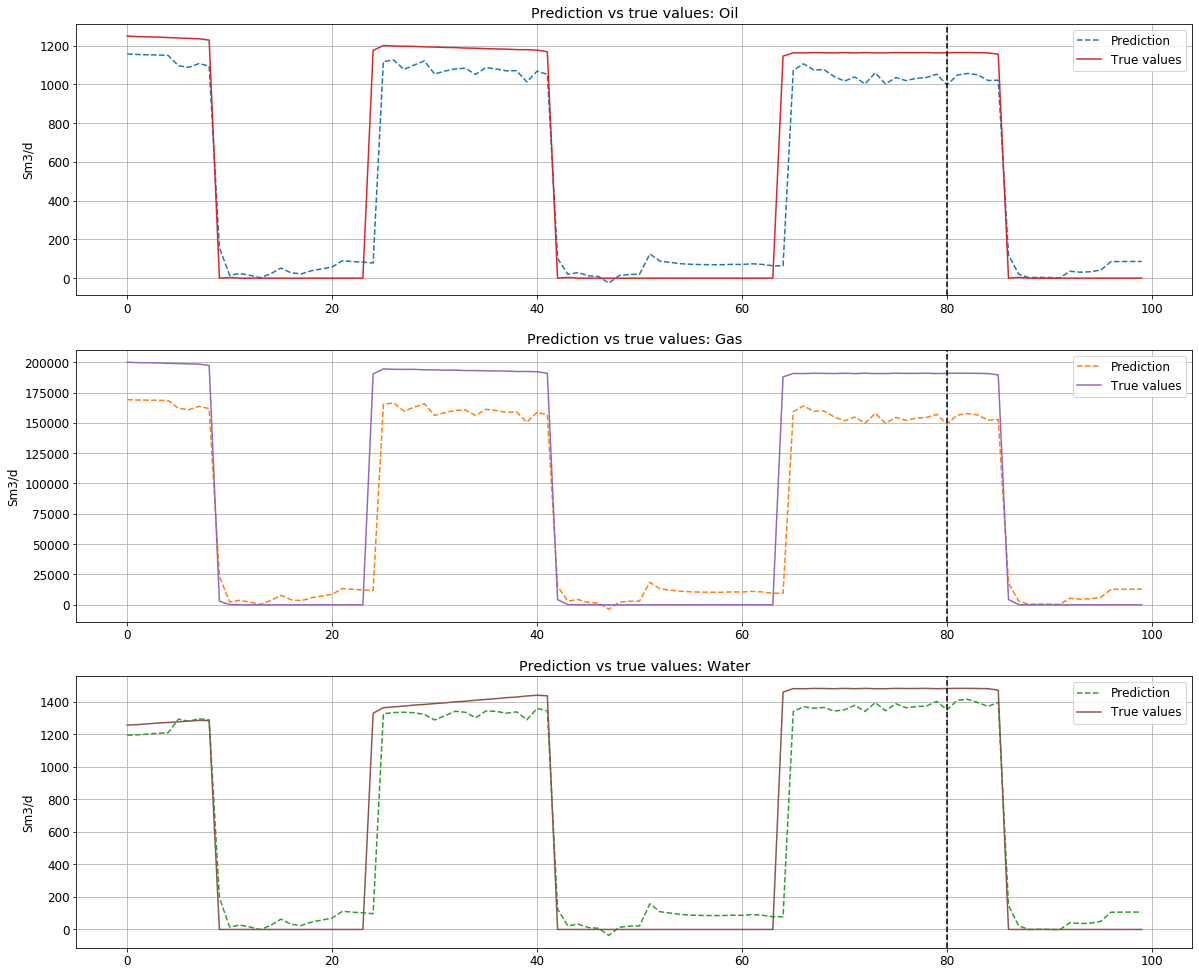

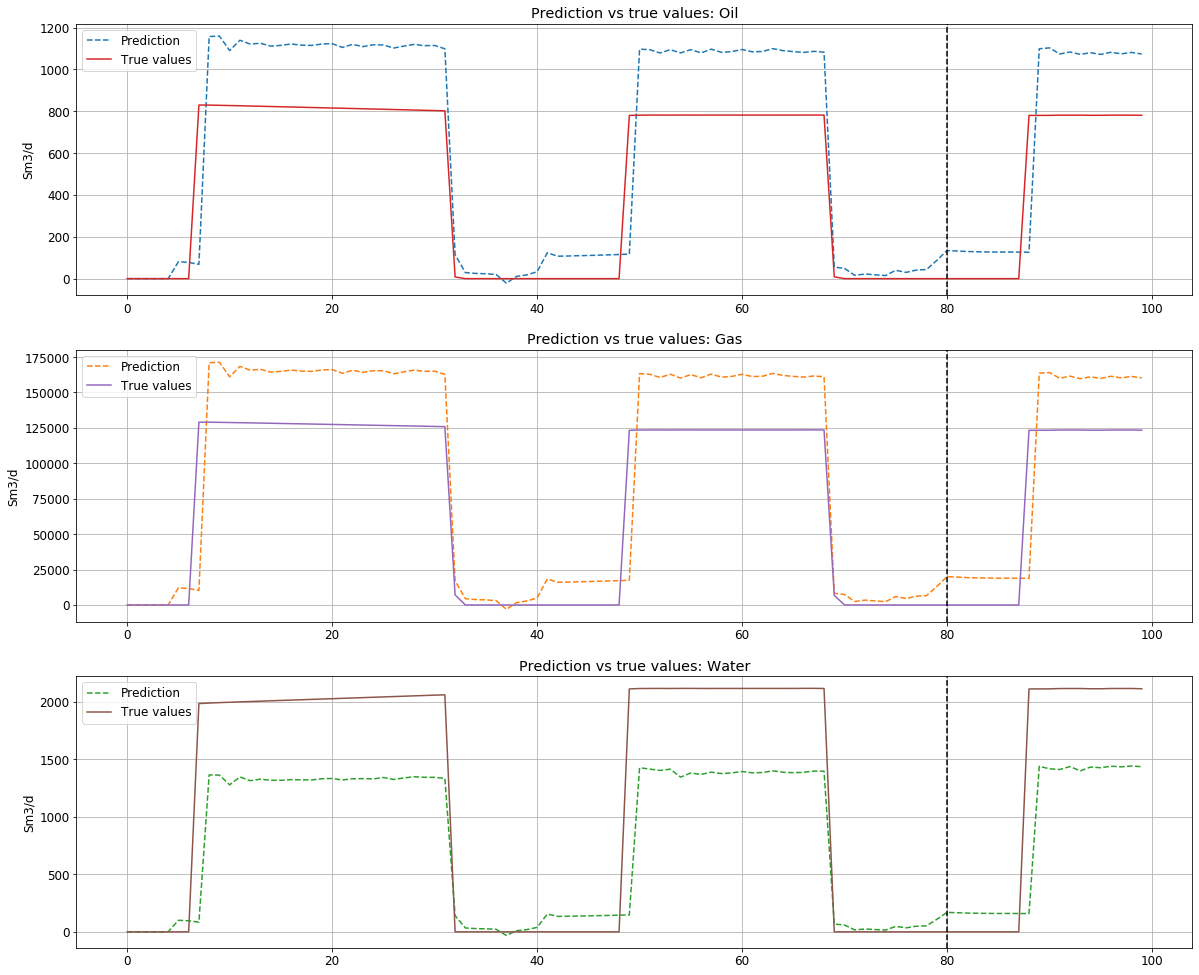

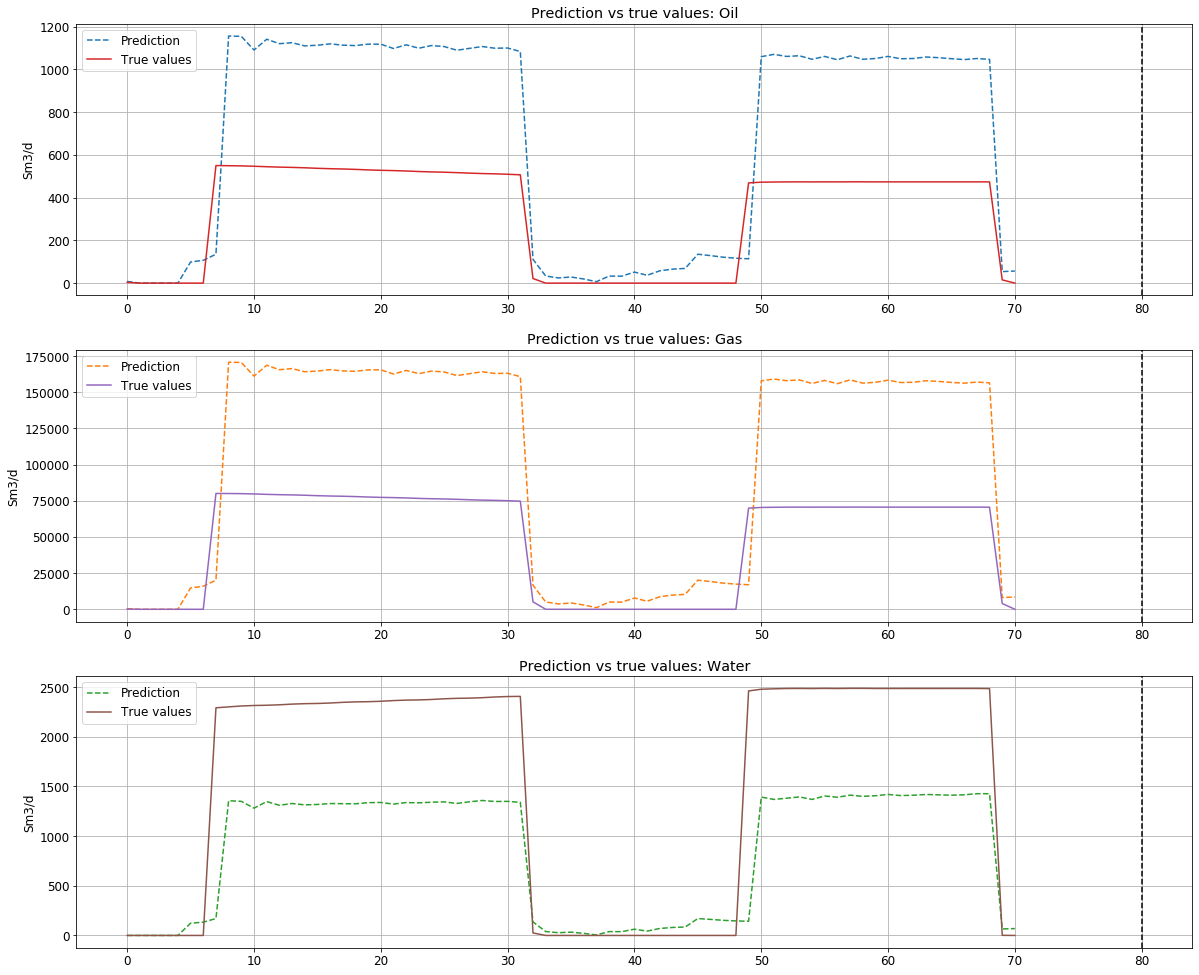

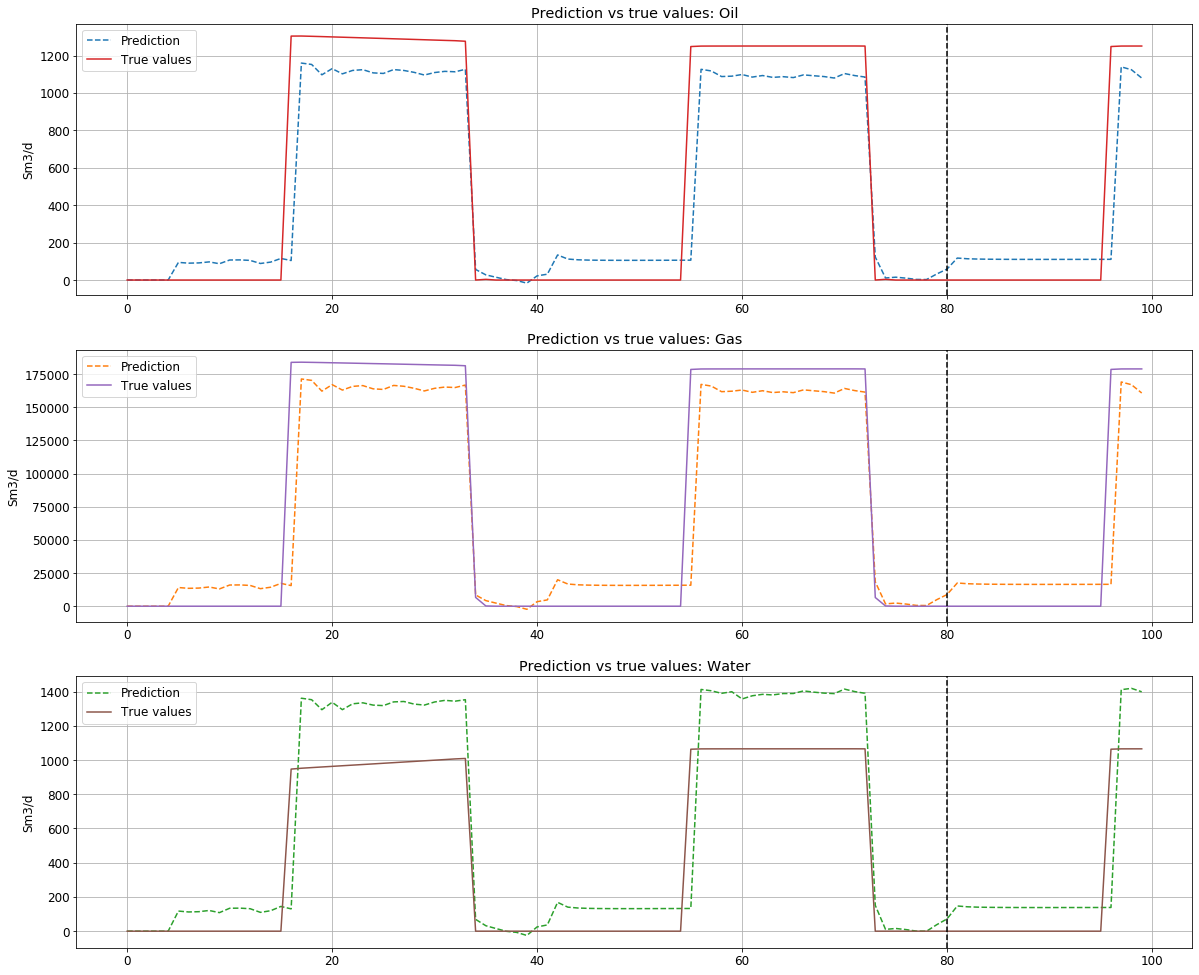

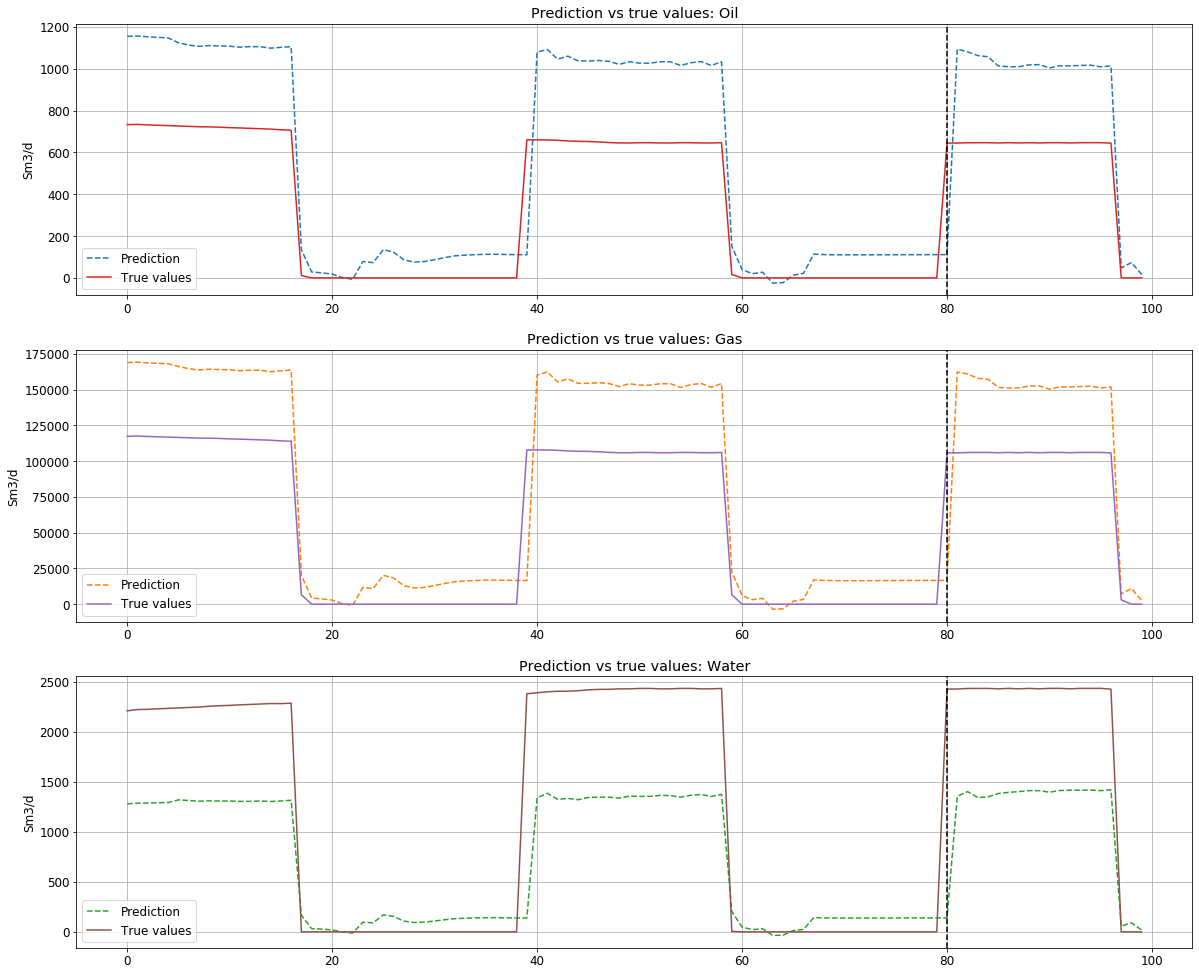

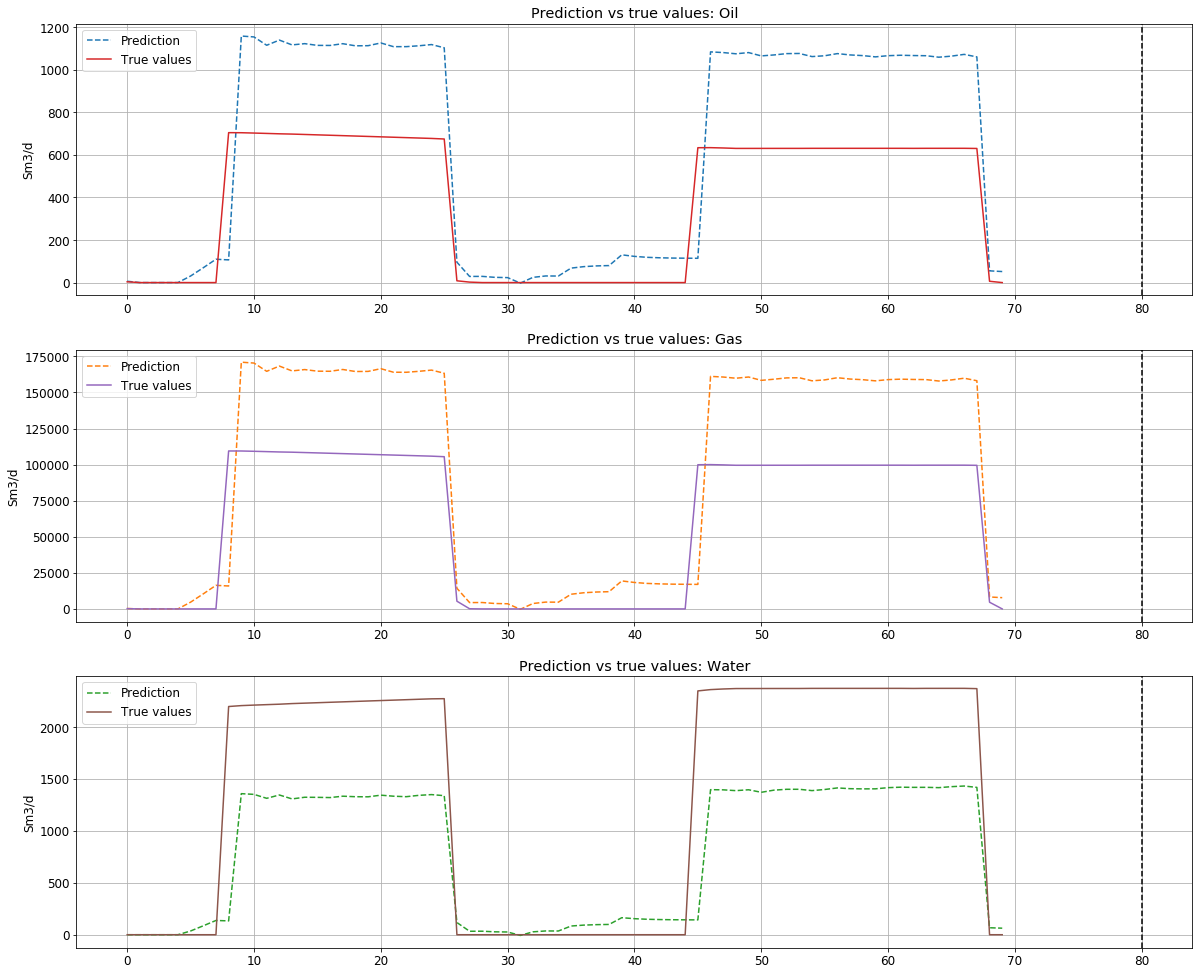

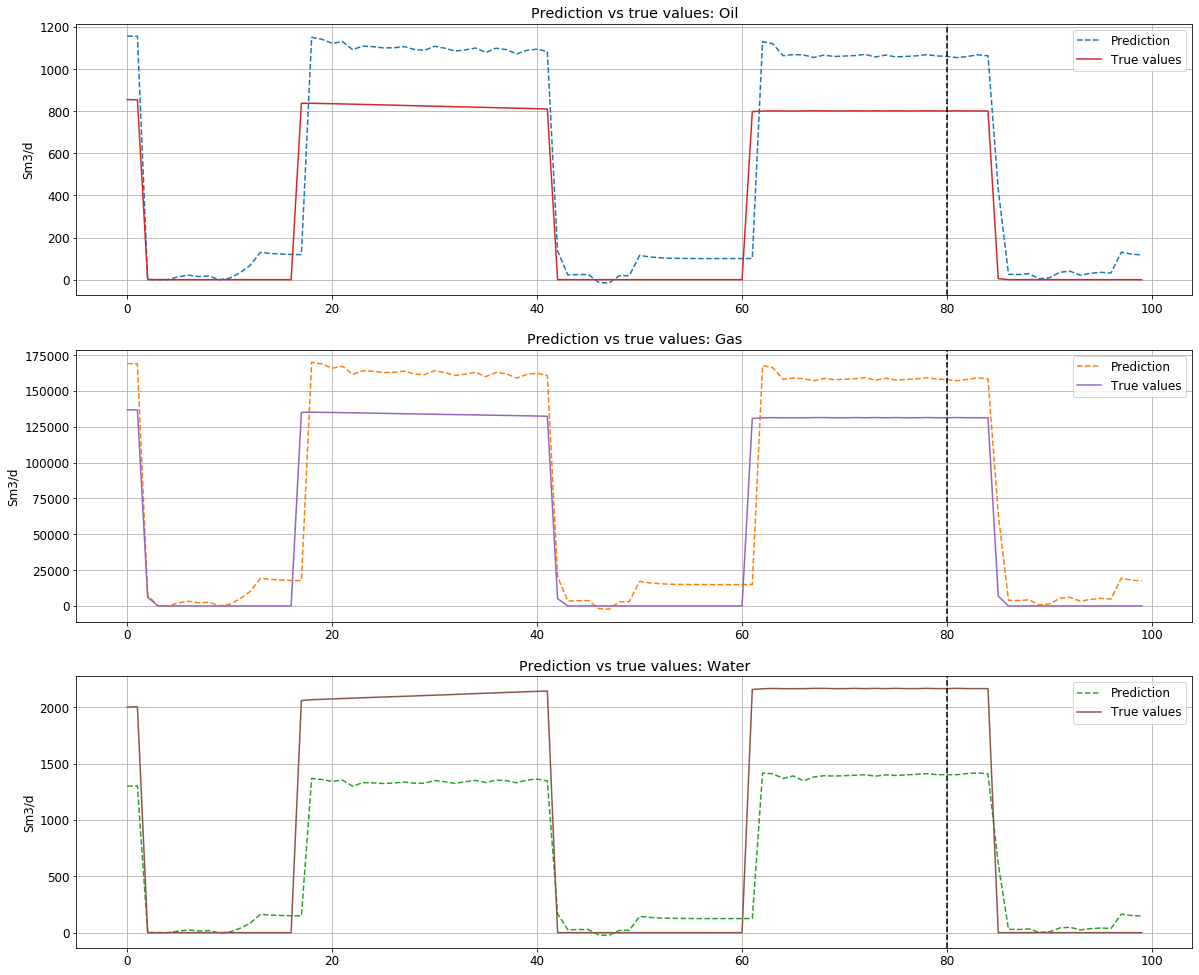

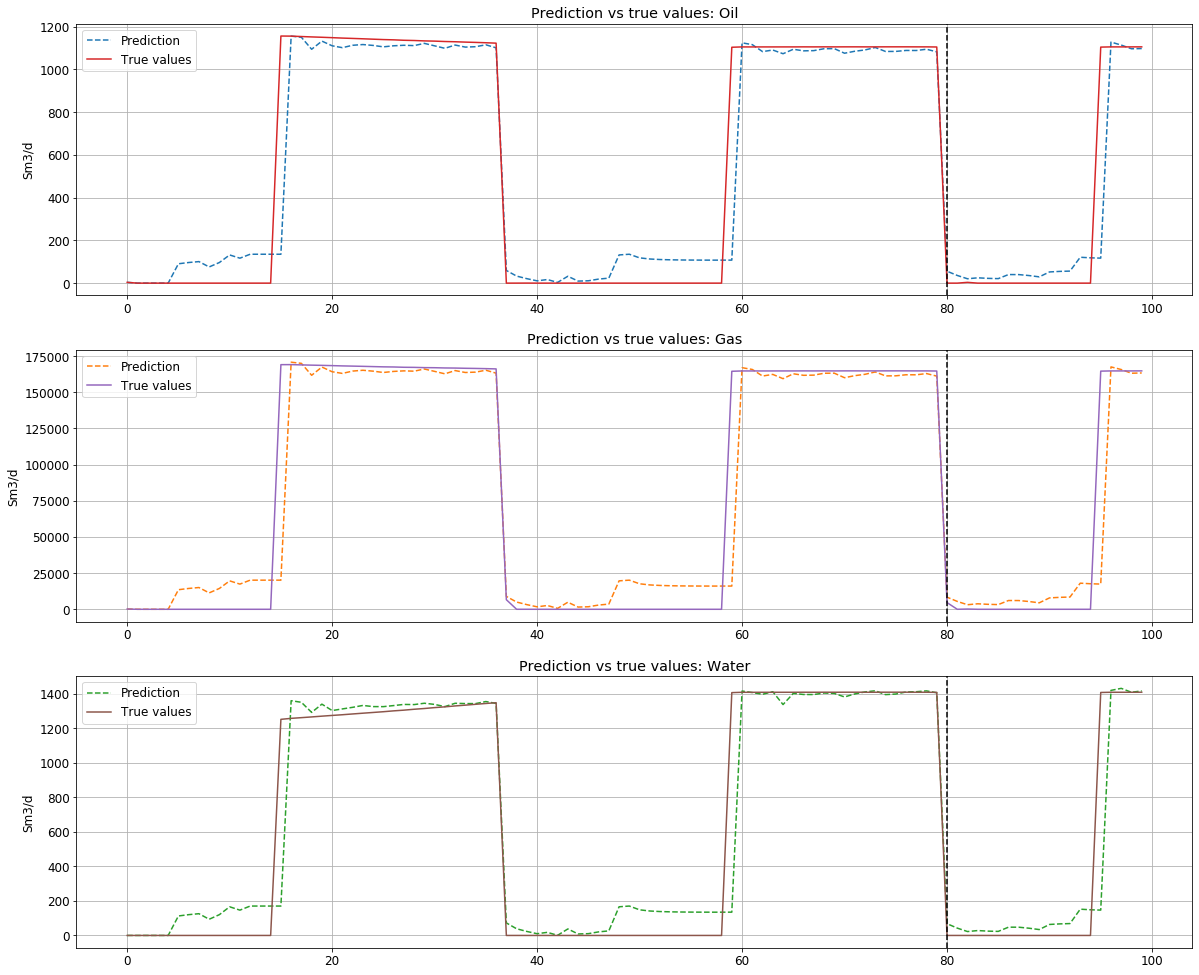

In [42]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [44]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')
print (f'{MODEL_NAME} saved')

TCN-1 saved


In [45]:
f'{STUDY_PATH}/{MODEL_NAME}.hdf'

'C:/Users/Asus/Desktop/Skoltech/Multiphase flows/data/Subsea_Study[4]-7-7/TCN-1.hdf'

# MLP

In [21]:
MODEL_NAME = 'MLP-1'
LOSS = 'mae'

In [22]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [23]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mae', optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 100
    batch_x = 30
    import tensorflow.keras.optimizers
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=10, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, max_depth=5, reg_alpha=1))

In [24]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [25]:
X_train_shuffle.shape, X_valid.shape

((50977, 30), (3209, 30))

In [26]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_train_shuffle, y_train_shuffle)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 50977 samples, validate on 3209 samples
Epoch 1/500
50977/50977 [==============================] - 3s 67us/step - loss: 0.1665 - val_loss: 0.1269
Epoch 2/500
50977/50977 [==============================] - 3s 53us/step - loss: 0.1003 - val_loss: 0.1462
Epoch 3/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0872 - val_loss: 0.1373
Epoch 4/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0794 - val_loss: 0.1354
Epoch 5/500
50977/50977 [==============================] - 3s 56us/step - loss: 0.0727 - val_loss: 0.1139
Epoch 6/500
50977/50977 [==============================] - 3s 57us/step - loss: 0.0664 - val_loss: 0.0929
Epoch 7/500
50977/50977 [==============================] - 3s 58us/step - loss: 0.0598 - val_loss: 0.0815
Epoch 8/500
50977/50977 [==============================] - 3s 60us/step - loss: 0.0547 - val_loss: 0.0747
Epoch 9/500
50977/50977 [==============================] - 3s 60us/step - loss: 0.0506 - val_loss: 0.06

50977/50977 [==============================] - 3s 55us/step - loss: 0.0328 - val_loss: 0.0395
Epoch 154/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0328 - val_loss: 0.0351
Epoch 155/500
50977/50977 [==============================] - 3s 56us/step - loss: 0.0328 - val_loss: 0.0355
Epoch 156/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0328 - val_loss: 0.0344
Epoch 157/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0327 - val_loss: 0.0352
Epoch 158/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0327 - val_loss: 0.0350
Epoch 159/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0327 - val_loss: 0.0353
Epoch 160/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0327 - val_loss: 0.0349
Epoch 161/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0328 - val_loss: 0.0347
Epoch 162/500
50977/50977 [===============

Epoch 304/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0320 - val_loss: 0.0296
Epoch 305/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0321 - val_loss: 0.0296
Epoch 306/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0320 - val_loss: 0.0298
Epoch 307/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0321 - val_loss: 0.0324
Epoch 308/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0320 - val_loss: 0.0296
Epoch 309/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0320 - val_loss: 0.0306
Epoch 310/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0321 - val_loss: 0.0301
Epoch 311/500
50977/50977 [==============================] - 3s 56us/step - loss: 0.0320 - val_loss: 0.0297
Epoch 312/500
50977/50977 [==============================] - 3s 56us/step - loss: 0.0320 - val_loss: 0.0301
Epoch 313/500
50977/50977 [=

Epoch 380/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0318 - val_loss: 0.0293
Epoch 381/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0318 - val_loss: 0.0332
Epoch 382/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0317 - val_loss: 0.0297
Epoch 383/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0317 - val_loss: 0.0297
Epoch 384/500
50977/50977 [==============================] - 3s 55us/step - loss: 0.0318 - val_loss: 0.0295
Epoch 385/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0318 - val_loss: 0.0297
Epoch 386/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0318 - val_loss: 0.0296
Epoch 387/500
50977/50977 [==============================] - 3s 53us/step - loss: 0.0318 - val_loss: 0.0299
Epoch 388/500
50977/50977 [==============================] - 3s 54us/step - loss: 0.0318 - val_loss: 0.0296
Epoch 389/500
50977/50977 [=

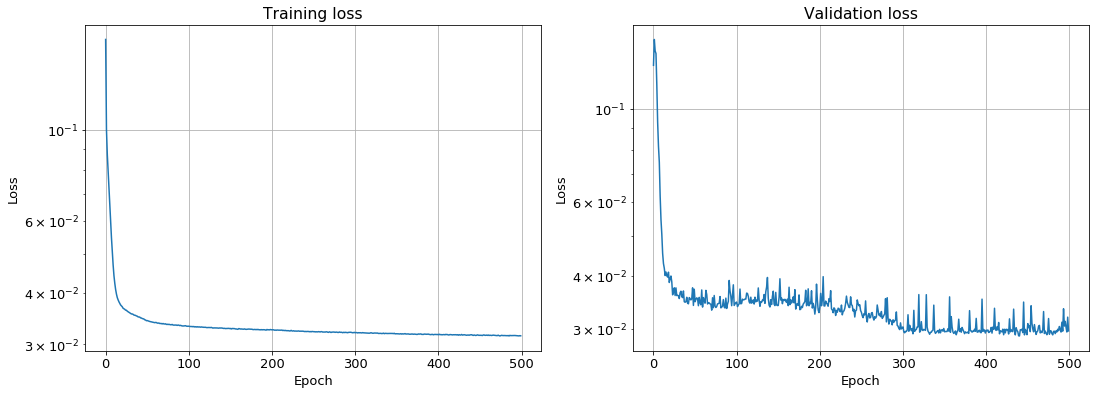

In [27]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

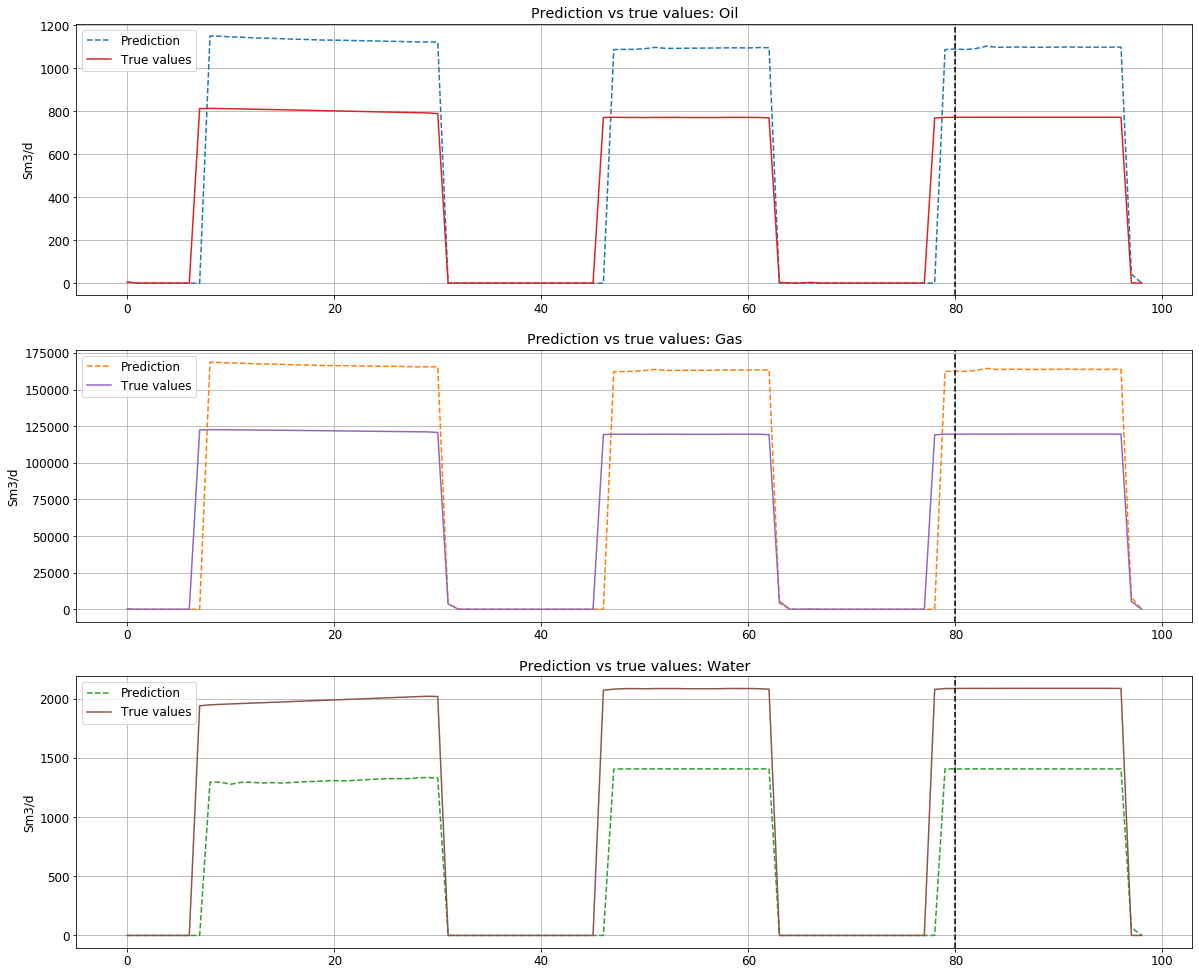

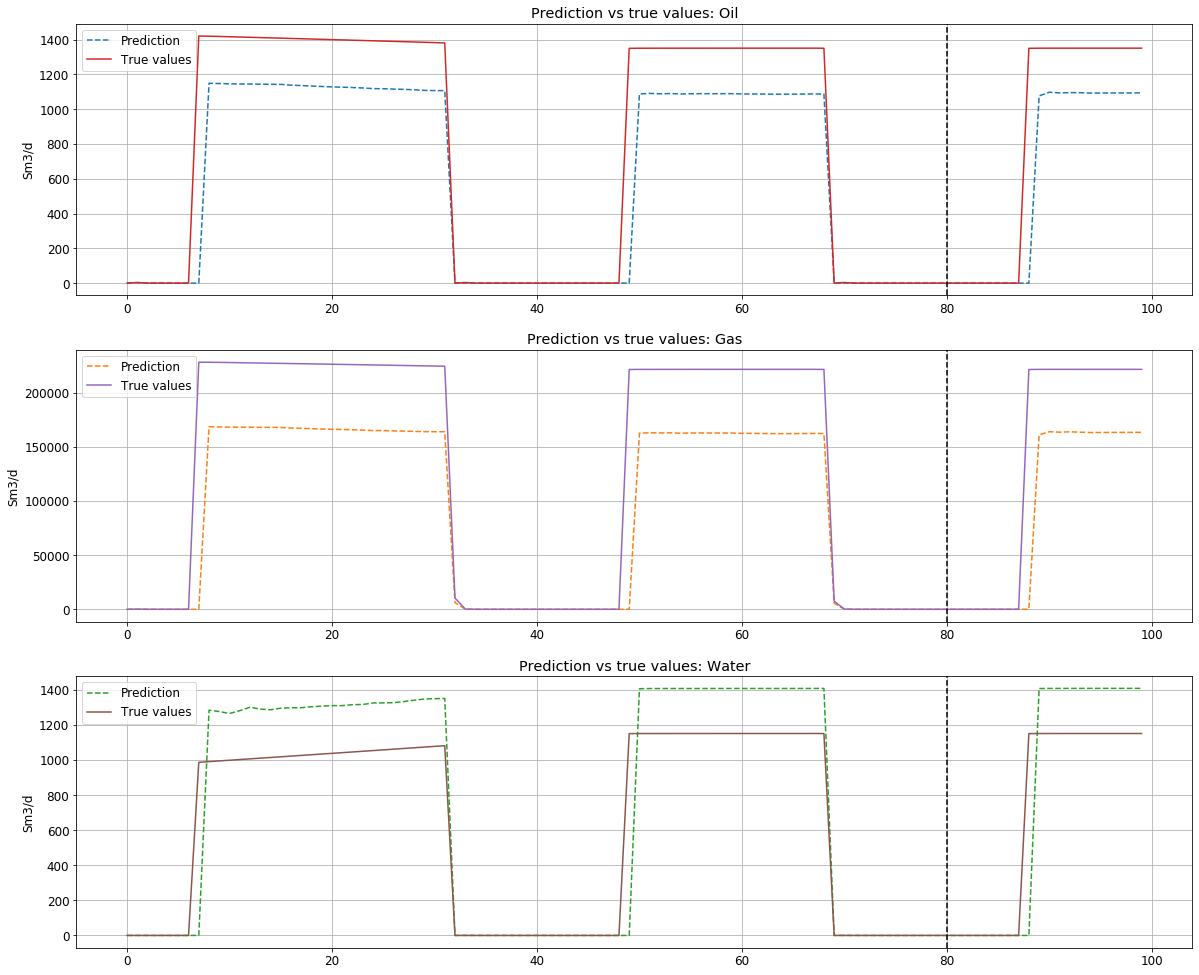

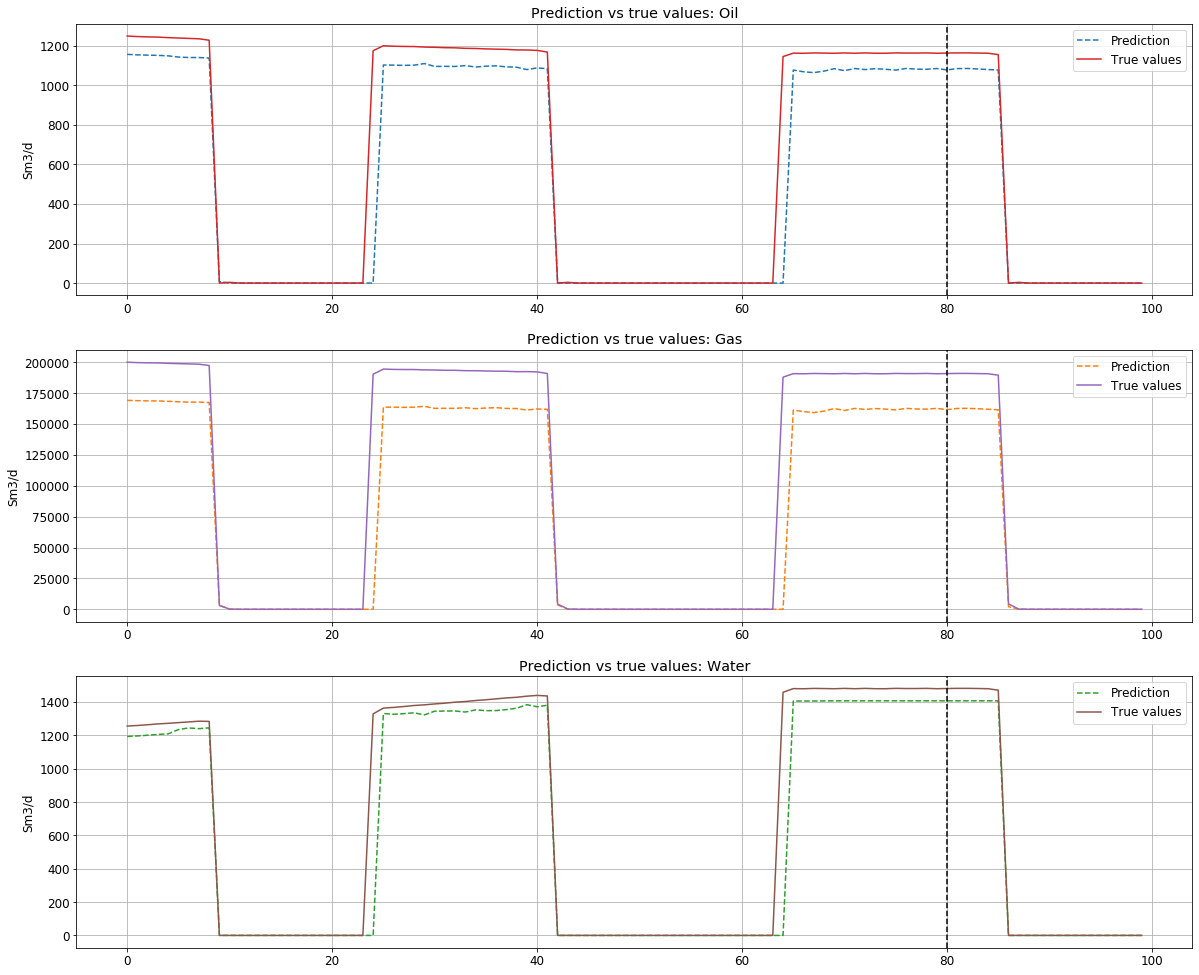

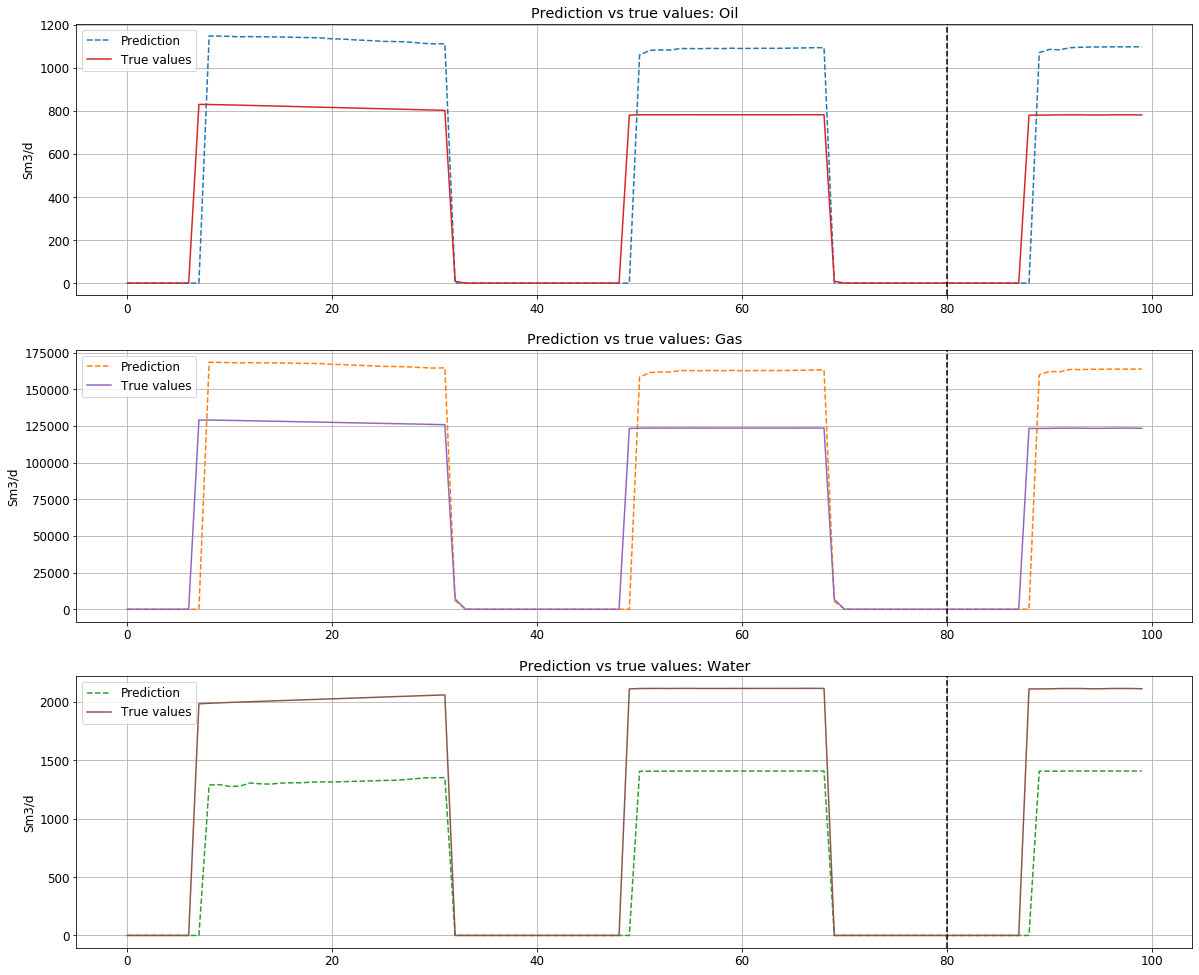

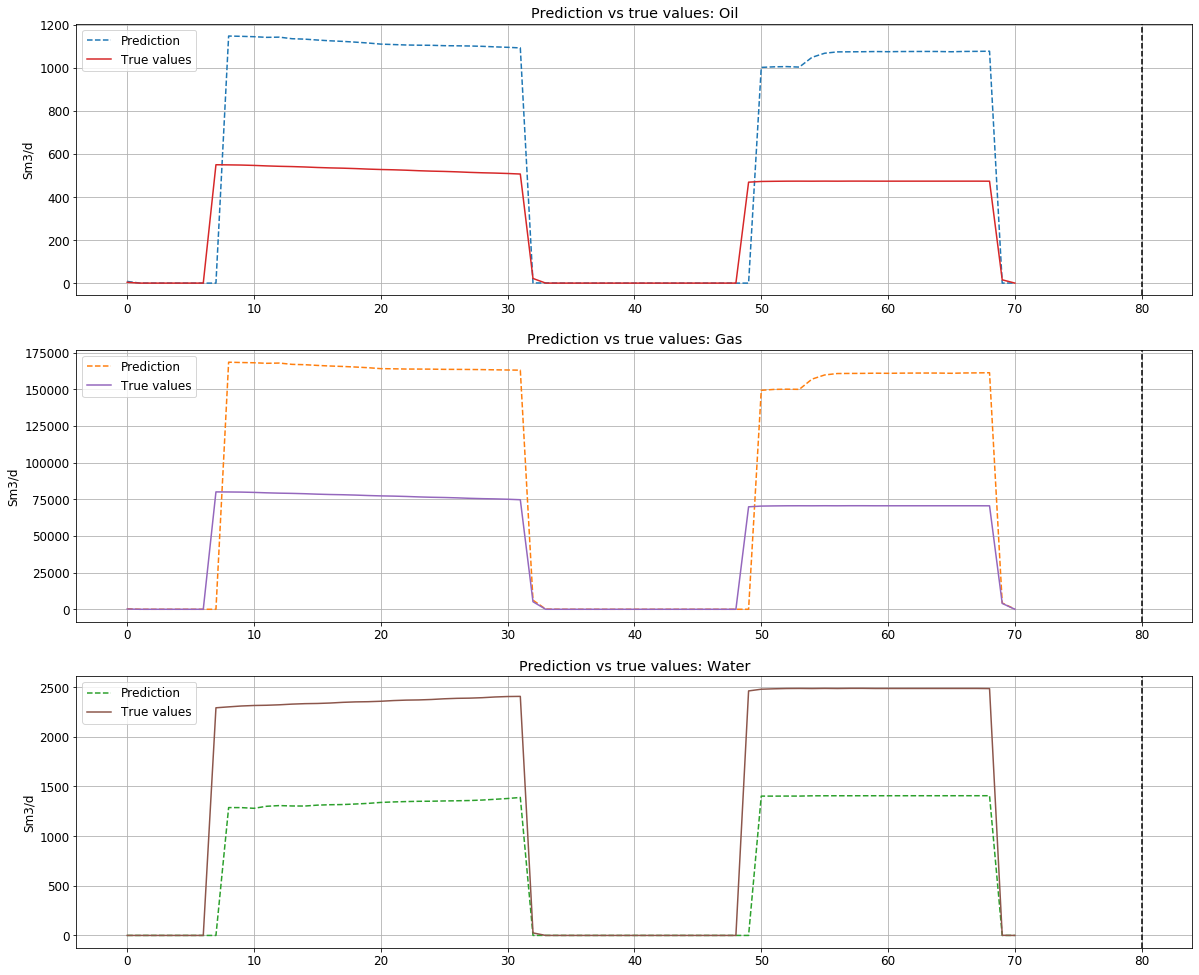

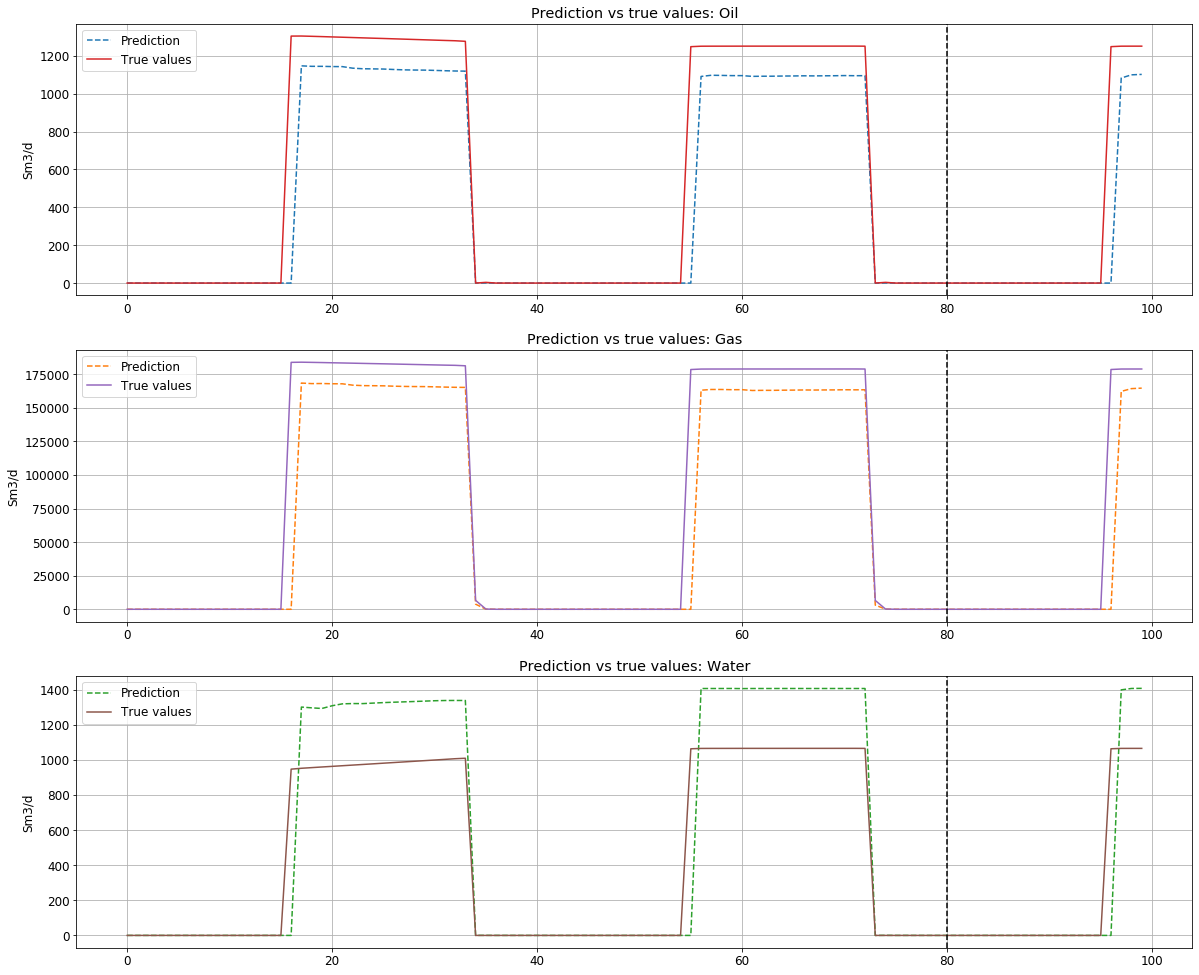

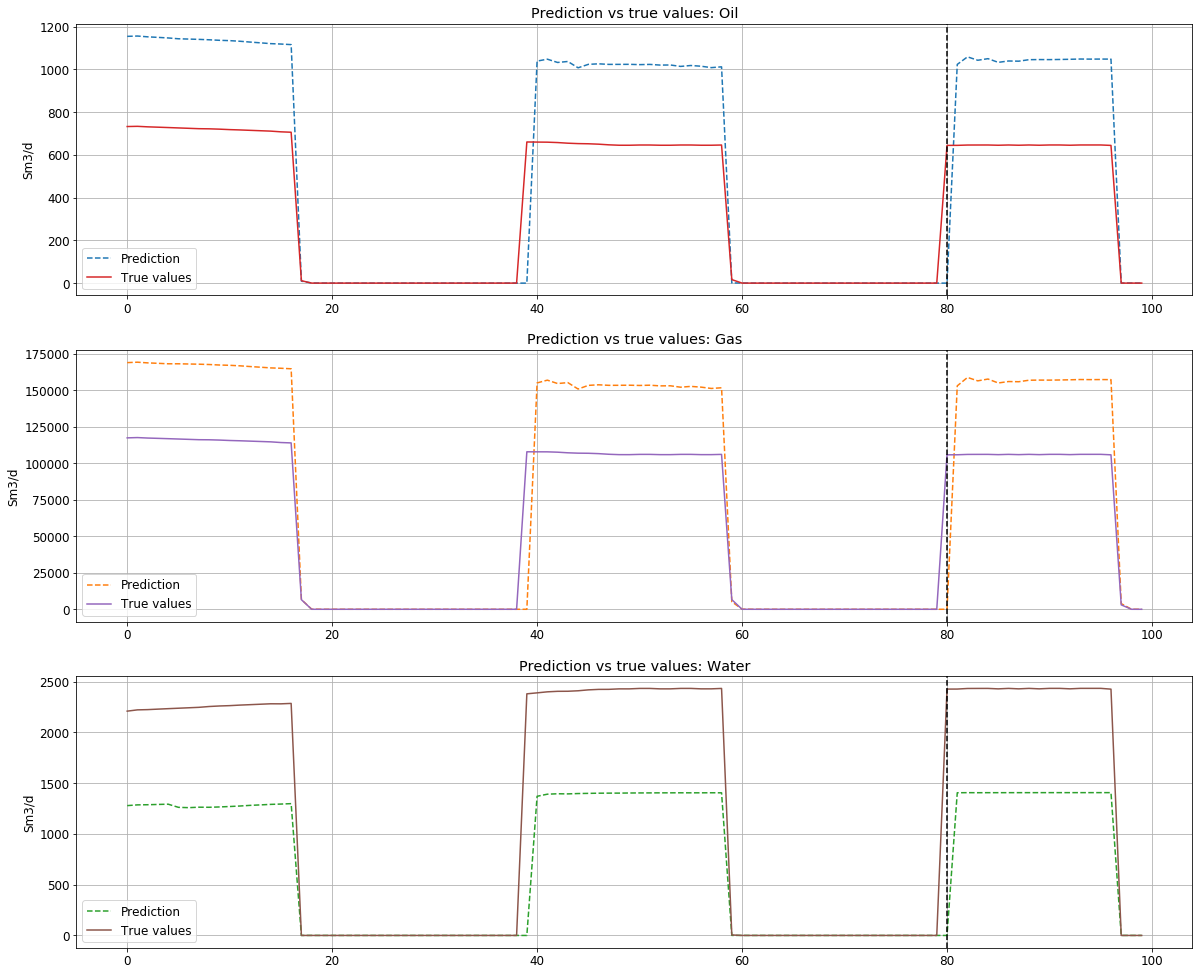

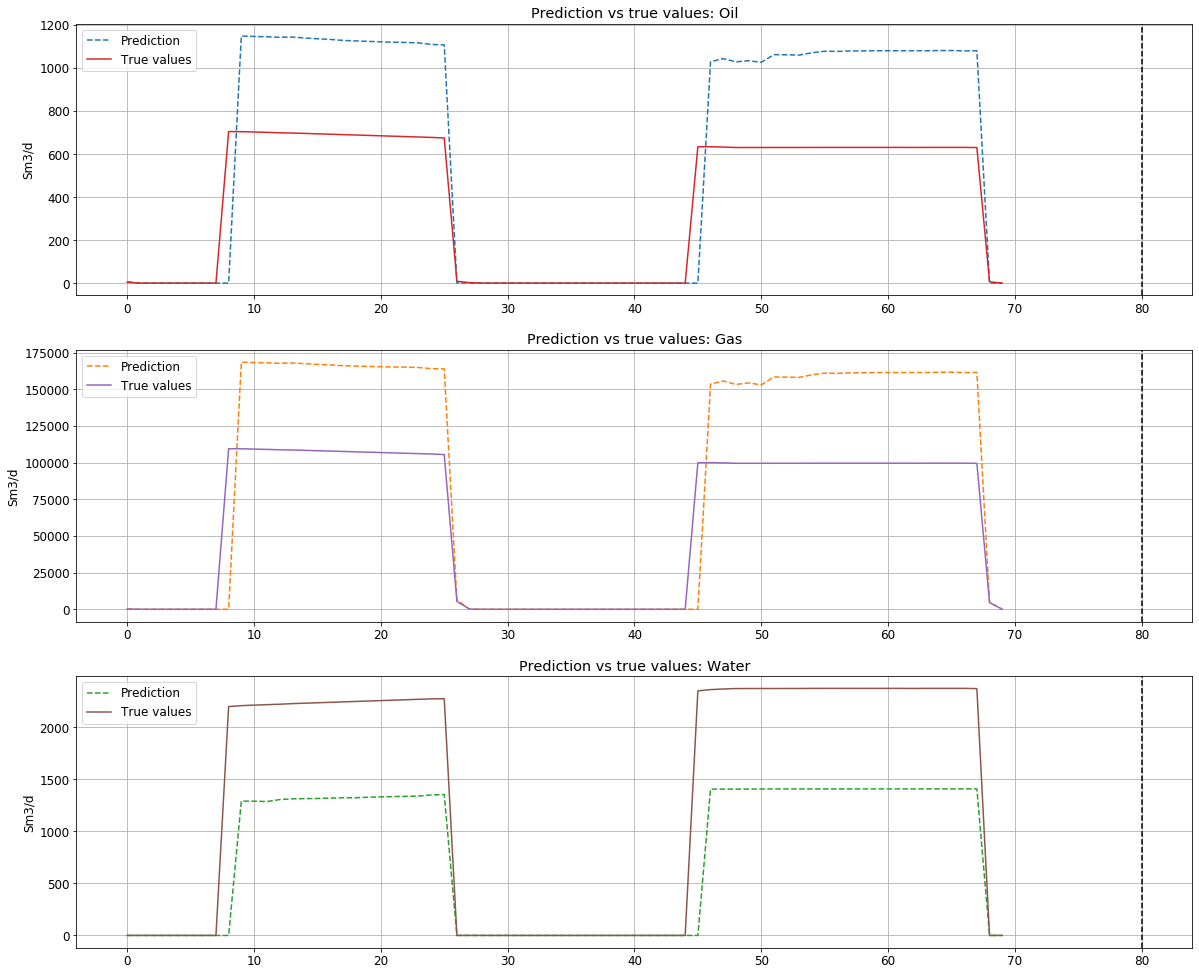

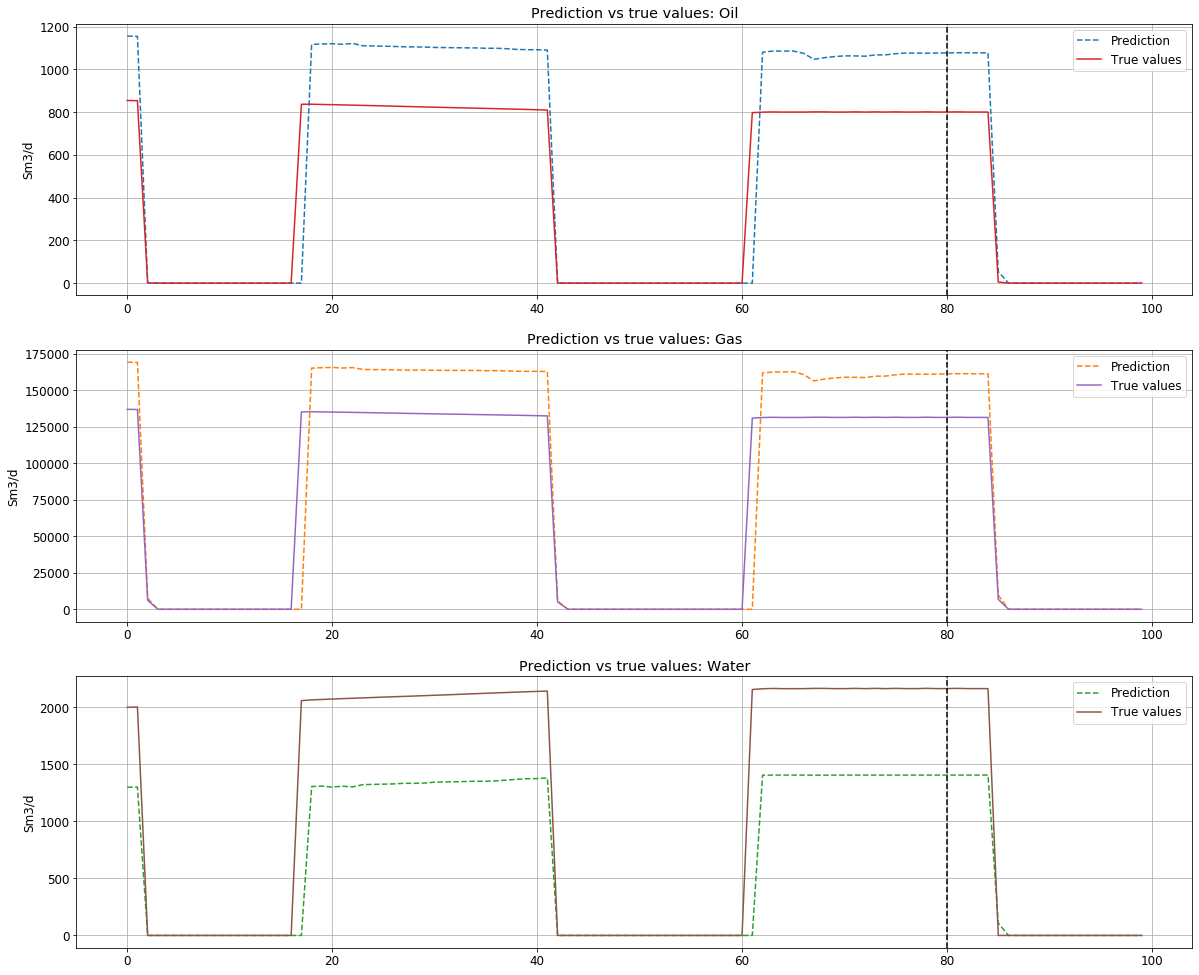

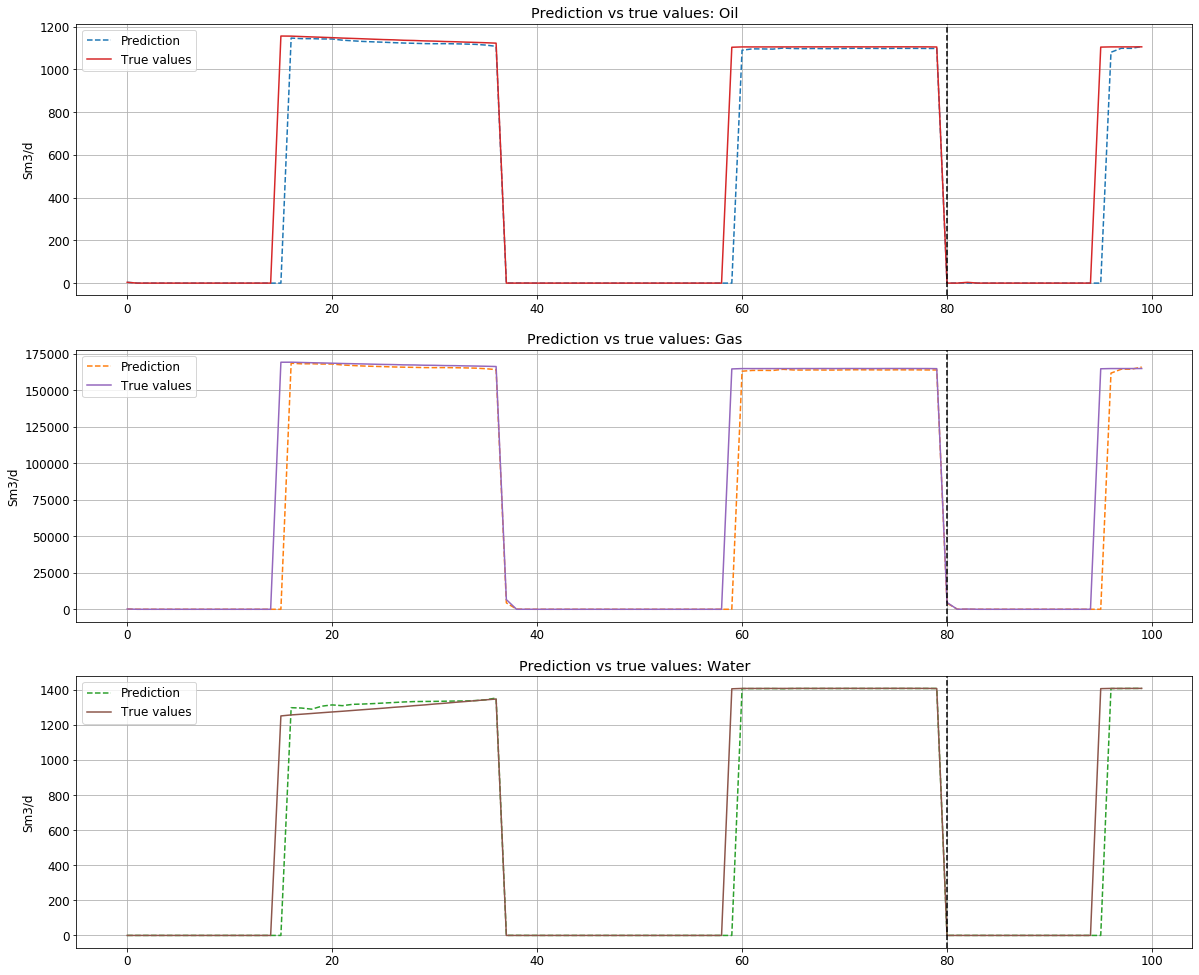

In [28]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [31]:
STUDY_PATH = STUDY_PATH + '-7'
STUDY_PATH

'C:/Users/Asus/Desktop/Skoltech/Multiphase flows/data/Subsea_Study[4]-7-7'

In [33]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')
print (f'{MODEL_NAME} saved')

MLP-1 saved
